In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy
from scipy import stats
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

import copy

%load_ext autoreload
%autoreload 2


# import gzip
# from cyvcf2 import VCF

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from itertools import combinations_with_replacement
from itertools import permutations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools
import figures as figures

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()


In [2]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)
# noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

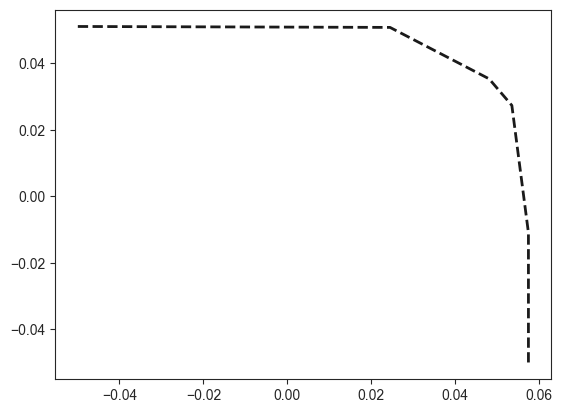

In [3]:
### Draw the old pareto front line from Li et al 2019
old_muts = merged_fitness[merged_fitness['source_publication'].isin(['Venkataram2015','Li2019'])]

points = old_muts[['FerPerHour_Li2019','ResPerHour_Li2019']].values
points = points[~np.isnan(points).any(axis=1)]

hull = scipy.spatial.ConvexHull(points)

pareto_line = (list(points[hull.vertices,0][5:-1])+[0],list(points[hull.vertices,1][5:-1])+[np.nanmax(old_muts['ResPerHour_Li2019'].values)])

### Draw a new "pareto" line using only 2day mutants from Levy et al  2015
levy2015 = merged_fitness[(merged_fitness['source_publication'].isin(['Venkataram2015'])) & 
                          (merged_fitness['evolution_condition'].isin(['Evo2D']))
                         ]
points = levy2015[['FerPerHour','ResPerHour']].values
points = points[~np.isnan(points).any(axis=1)]

hull = scipy.spatial.ConvexHull(points)

# pareto_line = (lis

# levy_pareto_line = (list(points[hull.vertices,0][1:5])+[0],
#                     list(points[hull.vertices,1][1:5])+[np.nanmax(levy2015['ResPerHour'].values)])
levy_pareto_line = ([np.nanmax(levy2015['FerPerHour'].values)]+list(points[hull.vertices,0][1:5])+[-0.05],
                    [-0.05]+list(points[hull.vertices,1][1:5])+[np.nanmax(levy2015['ResPerHour'].values)])

# plt.plot()
plt.plot(levy_pareto_line[0],levy_pareto_line[1], 'k--', lw=2)

xdata = 'FerPerHour'
ydata = 'ResPerHour'

wt_data = levy2015[levy2015['class_new'].isin(['adaptive_haploid','high_fitness_diploids'])]
# sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond,bw_method=0.4)
# plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')

In [4]:
### Now that we've drawn that line, let's purge the Li2019 mutants from the list


merged_fitness = merged_fitness[~merged_fitness['source_publication'].isin(['Li2019'])]

In [5]:
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

for anc in anc_list:
    for evo_cond in evo_cond_list:
        this_pairing = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['evolution_condition']==evo_cond)]
        pure_diploids = this_pairing[this_pairing['class_new']=='pure_diploids']
        adaptive_nondiploids = this_pairing[~this_pairing['class_new'].isin(['pure_diploids','neutral_haploids'])]
        print(anc,evo_cond,len(this_pairing),len(pure_diploids),len(adaptive_nondiploids))

WT Evo1D 0 0 0
WT Evo2D 482 236 119
WT Evo3D 0 0 0
CYR1 Evo1D 211 101 6
CYR1 Evo2D 529 224 62
CYR1 Evo3D 35 7 22
GPB2 Evo1D 166 84 9
GPB2 Evo2D 1215 229 13
GPB2 Evo3D 34 19 14
TOR1 Evo1D 201 163 12
TOR1 Evo2D 715 317 46
TOR1 Evo3D 2 0 2
IRA1_MIS Evo1D 186 83 15
IRA1_MIS Evo2D 142 16 90
IRA1_MIS Evo3D 32 2 30
IRA1_NON Evo1D 12 0 12
IRA1_NON Evo2D 95 0 95
IRA1_NON Evo3D 134 0 134


In [6]:
def count_tradeoffs(data_x,data_y,
                    error_x,error_y,
                    background_data_x,background_data_y,
                    background_error_x,background_error_y,
                    multiplier=1.96,use_both_errors=False,use_standard_error=False):
    
    if use_standard_error == True:
        background_error_x = background_error_x/len(background_error_x)
        background_error_y = background_error_y/len(background_error_y)
    
    if not use_both_errors:
    
        x_improved = (data_x>(background_data_x+multiplier*background_error_x))
        y_improved = (data_y>(background_data_y+multiplier*background_error_y))

        x_reduced = (data_x<(background_data_x-multiplier*background_error_x))
        y_reduced = (data_y<(background_data_y-multiplier*background_error_y))

        x_same = np.logical_and(~x_reduced,~x_improved)
        y_same = np.logical_and(~y_reduced,~y_improved)

    #     both_improved = np.logical_and(x_improved,y_improved)


        improvement_matrix = [[np.logical_and(x_reduced,y_reduced),np.logical_and(x_reduced,y_same),np.logical_and(x_reduced,y_improved)],
                              [np.logical_and(x_same,y_reduced),np.logical_and(x_same,y_same),np.logical_and(x_same,y_improved)],
                              [np.logical_and(x_improved,y_reduced),np.logical_and(x_improved,y_same),np.logical_and(x_improved,y_improved)]
                             ]

        both_indices = np.where(improvement_matrix[2][2])[0]

        improvement_matrix = [[np.sum(improvement_matrix[x][y]) for y in range(3)] for x in range(3)]
        
    else:
#         scipy.stats.ttest_ind_from_stats(data_x,error_x)
        
        
        x_improved = (data_x-multiplier*error_x>(background_data_x))
        y_improved = (data_y-multiplier*error_y>(background_data_y))
#                     reduced = (data[:,f]+multiplier*error[:,f]<(background_data[f]))

        x_reduced = (data_x+multiplier*error_x<(background_data_x))
        y_reduced = (data_y+multiplier*error_y<(background_data_y))
#         y_reduced = (data_y<(background_data_y-multiplier*background_error_y))

        x_same = np.logical_and(~x_reduced,~x_improved)
        y_same = np.logical_and(~y_reduced,~y_improved)

    #     both_improved = np.logical_and(x_improved,y_improved)


        improvement_matrix = [[np.logical_and(x_reduced,y_reduced),np.logical_and(x_reduced,y_same),np.logical_and(x_reduced,y_improved)],
                              [np.logical_and(x_same,y_reduced),np.logical_and(x_same,y_same),np.logical_and(x_same,y_improved)],
                              [np.logical_and(x_improved,y_reduced),np.logical_and(x_improved,y_same),np.logical_and(x_improved,y_improved)]
                             ]

        both_indices = np.where(improvement_matrix[2][2])[0]

        improvement_matrix = [[np.sum(improvement_matrix[x][y]) for y in range(3)] for x in range(3)]
    
    
    return improvement_matrix,len(data_x),both_indices

In [7]:
def bootstrap_tradeoffs(data_x,data_y,
                    error_x,error_y,
                    background_data_x,background_data_y,
                    background_error_x,background_error_y,
                    multiplier=0,use_both_errors=False,use_standard_error=False,n_resamples=100):
    
    resampling_matrix = np.zeros((n_resamples,3,3))
    
    for resampling in range(n_resamples):
        resampled_x = np.random.normal(data_x,error_x)
        resampled_y = np.random.normal(data_y,error_y)

        

        improvement_matrix,n_obs,both_indices = count_tradeoffs(resampled_x,resampled_y,
                                                                error_x,error_y,
                                                                background_data_x,background_data_y,
                                                                background_error_x,background_error_y,
                                                                multiplier=0,use_both_errors=True
                                                               )
#         print(np.asarray(improvement_matrix).shape)
        resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
  
    
    mean_matrix = np.mean(resampling_matrix,axis=0)
    std_matrix = np.std(resampling_matrix,axis=0)
    
    return mean_matrix,std_matrix
    

In [8]:
innovation_list = {}
total_tradeoffs_dict = {}
tradeoffs_dict = {}

multiplier = 1.96
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    for anc in ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
        
        print(anc)
        this_anc = merged_fitness[merged_fitness['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        total_tradeoffs = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,interesting_muts[ydata+'_relative'].values,
                                          interesting_muts[xdata+'_error'].values,interesting_muts[ydata+'_error'].values,
                             0,0,0,0,
                            multiplier=multiplier,use_both_errors=True)
        
        print(total_tradeoffs)

FerPerHour ResPerHour
WT
(array([[0.01428571, 0.        , 0.01731092],
       [0.        , 0.        , 0.        ],
       [0.10915966, 0.        , 0.8592437 ]]), array([[0.00969123, 0.        , 0.01138772],
       [0.        , 0.        , 0.        ],
       [0.02372354, 0.        , 0.02541583]]))
CYR1
(array([[0.00922222, 0.        , 0.483     ],
       [0.        , 0.        , 0.        ],
       [0.077     , 0.        , 0.43077778]]), array([[0.00903423, 0.        , 0.0226326 ],
       [0.        , 0.        , 0.        ],
       [0.02121349, 0.        , 0.02862508]]))
GPB2
(array([[0.00777778, 0.        , 0.41638889],
       [0.        , 0.        , 0.        ],
       [0.10583333, 0.        , 0.47      ]]), array([[0.01307622, 0.        , 0.0445303 ],
       [0.        , 0.        , 0.        ],
       [0.03636556, 0.        , 0.05822477]]))
TOR1
(array([[0.00433333, 0.        , 0.27783333],
       [0.        , 0.        , 0.        ],
       [0.0275    , 0.        , 0.69033333]]

In [9]:
def count_tradeoffs_many(data,error,
                    error_x,error_y,
                    background_data,
                    background_error,
                    multiplier=1.96,use_both_errors=False):
    
    improvement_dictionary = {}
    
    n_conditions = data.shape[1]
    
#     improvement_matrix = copy.copy(np.zeros([3]*n_conditions))
    improvement_matrix = np.empty((3,3,3))
    
#     for e,filter_set in enumerate(combinations_with_replacement(['<','=','>'],n_conditions)):
    for e,filter_set in enumerate(product(['<','=','>'],repeat=n_conditions)):
#     print(filter_set)
        
        filtered_set = []
        
        for f,this_filter in enumerate(filter_set):
        
            if this_filter == '<':
                
                if use_both_errors:
                    filtered_set.append((data[:,f]+multiplier*error[:,f]<(background_data[f])))
                else:
                    filtered_set.append((data[:,f]<(background_data[f]-multiplier*background_error[f])))
#                 print(f,'<',np.sum((data[:,f]<(background_data[f]-multiplier*background_error[f]))))
                
            elif this_filter == '=':
            
                if use_both_errors:
                
                    improved = (data[:,f]-multiplier*error[:,f]>(background_data[f]))
                    reduced = (data[:,f]+multiplier*error[:,f]<(background_data[f]))
                
                    filtered_set.append(np.logical_and(~improved,~reduced))
                else:
                    improved = (data[:,f]>(background_data[f]+multiplier*background_error[f]))
                    reduced = (data[:,f]<(background_data[f]-multiplier*background_error[f]))
                
                    filtered_set.append(np.logical_and(~improved,~reduced))
#                 print(f,'=',np.sum(np.logical_and(~improved,~reduced)))
                
            elif this_filter == '>':
            
                if use_both_errors:
                    filtered_set.append((data[:,f]-multiplier*error[:,f]>(background_data[f])))
                else:
                    filtered_set.append((data[:,f]>(background_data[f]+multiplier*background_error[f])))
#                 print(f,'>',np.sum((data[:,f]>(background_data[f]+multiplier*background_error[f]))))
        
        improvement_dictionary[filter_set] = copy.copy(np.sum(np.logical_and.reduce(filtered_set)))
        
        indices = [i for f in filter_set for i, x in enumerate(['<','=','>'])  if f == x ]
        
#         print(filter_set,indices,np.sum(np.logical_and.reduce(filtered_set)))

        improvement_matrix[tuple(indices)] = copy.copy(np.sum(np.logical_and.reduce(filtered_set)))
    
    return improvement_matrix,data.shape[0],improvement_dictionary

In [10]:
total_tradeoffs_dict = {}

ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['CYR1','GPB2','TOR1','IRA1_MIS'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

# ancestor_list = [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']]

data_list = ['FerPerHour','ResPerHour','StaPerHour']
multiplier = 1.96
multiplier = 1.0

# data_list = ['FerPerHour_relative','ResPerHour_relative','StaPerHour_relative']
# multiplier = 0

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']
    
for anc_list in ancestor_list:
          
    this_anc = noLi2019[noLi2019['ancestor'].isin(anc_list)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
    
    this_neutral_haploid = this_anc[this_anc['barcode'].isin(these_neutral_haploids)]
#     this_neutral_haploid = this_anc[this_anc['barcode'].isin(these_neutral_haploids)]

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    
    if 'relative' not in data_list[0]:
        if anc != 'IRA1_NON': 
            data_mean = []
            data_error = []

            for data in data_list:

                data_mean.append(np.nanmean(this_neutral_haploid[data].values))
                data_error.append(np.nanstd(this_neutral_haploid[data].values))

        else:
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
            data_mean = background_mutant[data_list].values[0]
            data_error = background_mutant[[data+'_error' for data in data_list]].values[0]
    else:
        data_mean = [0]*len(data_list)
        data_error = [0]*len(data_list)


#     total_tradeoffs = count_tradeoffs_many(interesting_muts[data_list].values,
#                              data_mean,
#                             data_error,
#                             multiplier=multiplier)
    


#     print(anc_list)
#     for k,e in total_tradeoffs[-1].items():
#             if ('>' in k) & (e!= 0):
#                 print(f'{k}: {e}({e/total_tradeoffs[1]:.3f})' )
    for evo_set in [['Evo2D','Evo3D'],['Evo2D'],['Evo3D']]:
#     for evo_set in [['Evo3D']]:

        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

        total_tradeoffs = count_tradeoffs_many(this_data[data_list].values,
                                               this_data[[data+'_error' for data in data_list]].values,
                    data_mean,
                    data_error,
                    multiplier=multiplier,use_both_errors=True)
            
#         print(anc_list,evo_set,total_tradeoffs[1],'\n',total_tradeoffs[0],'\n',total_tradeoffs[0]/total_tradeoffs[1])
        if total_tradeoffs[1] > 0:
            print(anc_list,evo_set,total_tradeoffs[1])
            singles = 0
            doubles = 0
            triples = 0
            for k,e in total_tradeoffs[-1].items():
                if ('>' in k) & (e!= 0):
                    print(f'{k}: {e}({e/total_tradeoffs[1]:.3f})' )
                    if k.count('>') == 1:
                        singles += e

                    elif k.count('>') == 2:
                        doubles += e

                    elif k.count('>') == 3:
                        triples += e

            print(f'singles: {singles}({singles/total_tradeoffs[1]:.3f})')
            print(f'doubles: {doubles}({doubles/total_tradeoffs[1]:.3f})')
            print(f'triples: {triples}({triples/total_tradeoffs[1]:.3f})')
            
            
            

TypeError: count_tradeoffs_many() missing 2 required positional arguments: 'background_data' and 'background_error'

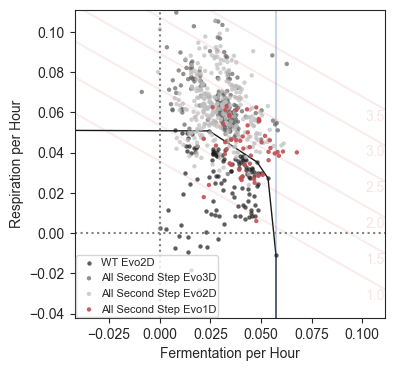

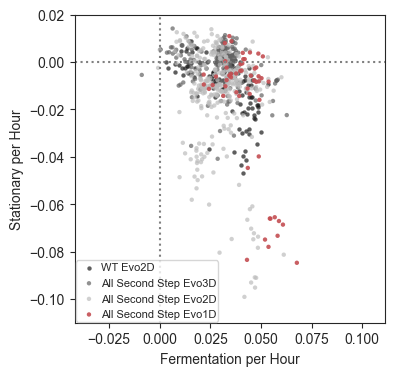

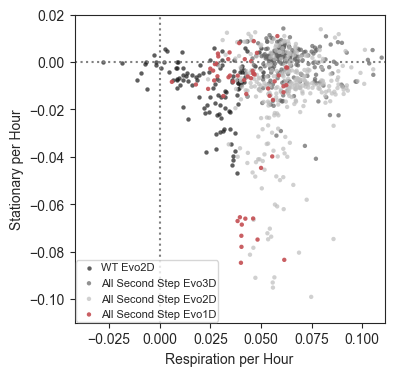

In [125]:
with_1day_colors = {'Evo1D':'r','Evo2D':'#bdbdbd','Evo3D':'#636363'}

multiplier = 0.0 

innovation_list = {}

evo_cond_set = ['Evo3D','Evo2D','Evo1D']

fitness_colorby = 'Fit2D_early_fitness'

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    fig = plt.figure(figsize=(4,4))
        
    if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
        for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
            ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
            resps = (fitness-16*ferms)/28 # 2day = 16*F
            
            plt.plot(ferms,resps,color='r',alpha=0.1)
            plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color='r',alpha=0.15,ha='right',va='top')
    
    alpha = 0.7

    this_anc = noLi2019[noLi2019['ancestor'].isin(['WT'])]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition']=='Evo2D']
    wt_data = interesting_muts[interesting_muts['evolution_condition']=='Evo2D']
    
    sc = plt.scatter(wt_data[xdata].values,wt_data[ydata].values,
                                color='k',
                                alpha=alpha,
                                marker='o',s=10,linewidths=0,
                     label=f'WT Evo2D')
    
#     if xdata == 'FerPerHour' and ydata == 'ResPerHour':
    
    
    
        
    
    
    for evo_i,evo_cond in enumerate(evo_cond_set):

        this_anc = noLi2019[noLi2019['ancestor'].isin(['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        if evo_cond == 'Evo1D':
            alpha = 0.9
        else:
            alpha = 0.7
        
        sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[with_1day_colors[evo_cond] for anc in this_data['ancestor'].values],
                                alpha=alpha,
                                marker='o',s=10,linewidths=0,
                         label=f'All Second Step {evo_cond}')
        
    if xdata == 'FerPerHour' and ydata == 'ResPerHour':
        plt.plot(levy_pareto_line[0],levy_pareto_line[1],color='k',lw=1,zorder=0)
        plt.axvline(np.max(wt_data['FerPerHour']),color='b',alpha=0.3,zorder=0)
        
        above_wt = merged_fitness[(merged_fitness['FerPerHour']-2*merged_fitness['FerPerHour_error']) > np.max(wt_data['FerPerHour'])]
        evo1d_above = above_wt[above_wt['evolution_condition']=='Evo1D']
        
#         plt.gca().annotate('', xy=(evo1d_above[xdata].values[0]+0.001, evo1d_above[ydata].values[0]+0.001), 
#                         xytext=(evo1d_above[xdata].values[0]+0.01, evo1d_above[ydata].values[0]+0.01),
# #                            arrowprops=dict(arrowstyle="->",head_length=0.5,head_width=0.1)
#             arrowprops=dict(facecolor='r',width=2,headwidth=4,headlength=8)
#                           )

    plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(tools.labels[xdata])
    plt.ylabel(tools.labels[ydata])

    plt.axvline(0,color='gray',linestyle=':')
    plt.axhline(0,color='gray',linestyle=':')
    
    
    
    plt.legend(fontsize=8,handletextpad=0.05,borderpad=0.2,loc='lower left',borderaxespad=0.1)
    
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/Evo1D_tradeoffs_{xdata}_{ydata}_simple.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/Evo1D_tradeoffs_{xdata}_{ydata}_simple.png',bbox_inches='tight',dpi=300)
       

In [46]:
print(np.max(wt_data['FerPerHour']))
merged_fitness[(merged_fitness['FerPerHour']-2*merged_fitness['FerPerHour_error']) > np.max(wt_data['FerPerHour'])
              ][['barcode','ancestor','evolution_condition','FerPerHour','FerPerHour_error','gene','all_mutations_verbose']]

0.0574375718692986


,barcode,ancestor,evolution_condition,FerPerHour,FerPerHour_error,gene,all_mutations_verbose
5,TATCGAAACCCAAAGAGATTTAATCG_CGATCAAAGACTAACTTAT...,IRA1_MIS,Evo3D,0.062750,0.001896,IRA1+MKT1+SPB1,II:441856:C:T:MMS4:synonymous_variant:c.342C>T...
1384,AATGCAATAATGAAATGATTTGAGGA_CATCGAAGGGAAAACCAGC...,IRA1_NON,Evo1D,0.067729,0.001857,ALD5,II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu...


In [38]:
merged_fitness[(merged_fitness['source_publication']=='This_study') & 
    (merged_fitness['evolution_condition']=='Evo1D') & 
    ~p.isnull(merged_fitness['all_mutations_verbose'])
              ][['barcode','ancestor','gene','all_mutations_verbose']].to_csv('~/Downloads/Evo1D_mutations.csv')

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_17381/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_17381/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_17381/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_17381/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_17381/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resam

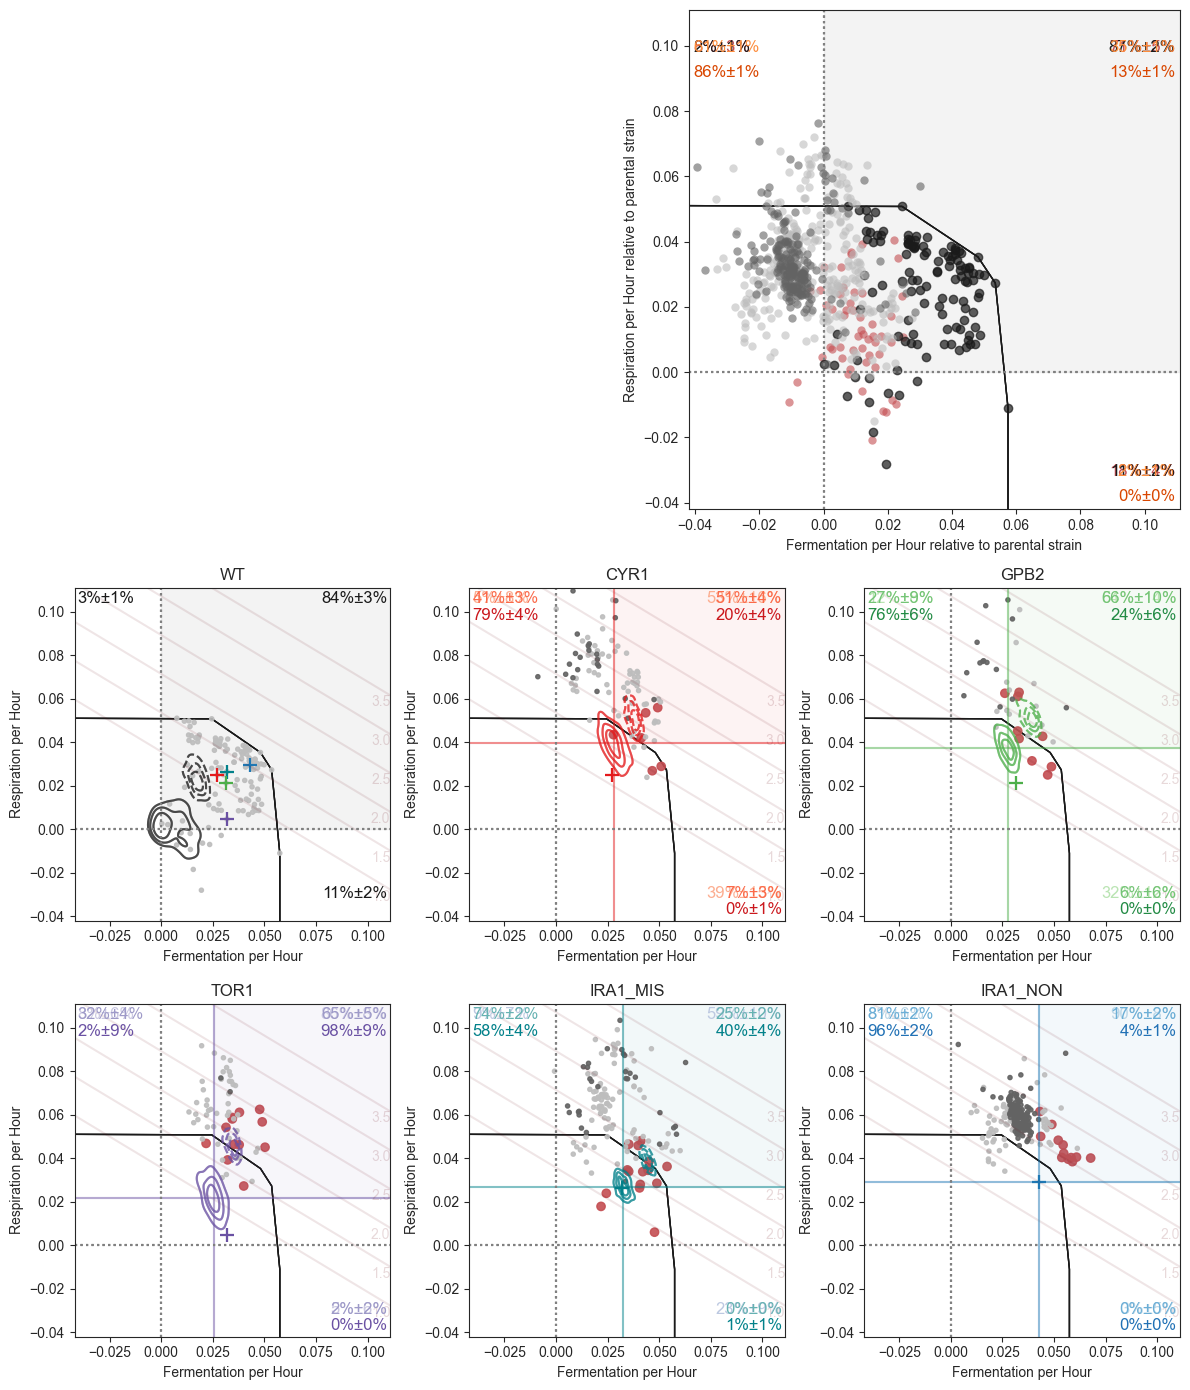

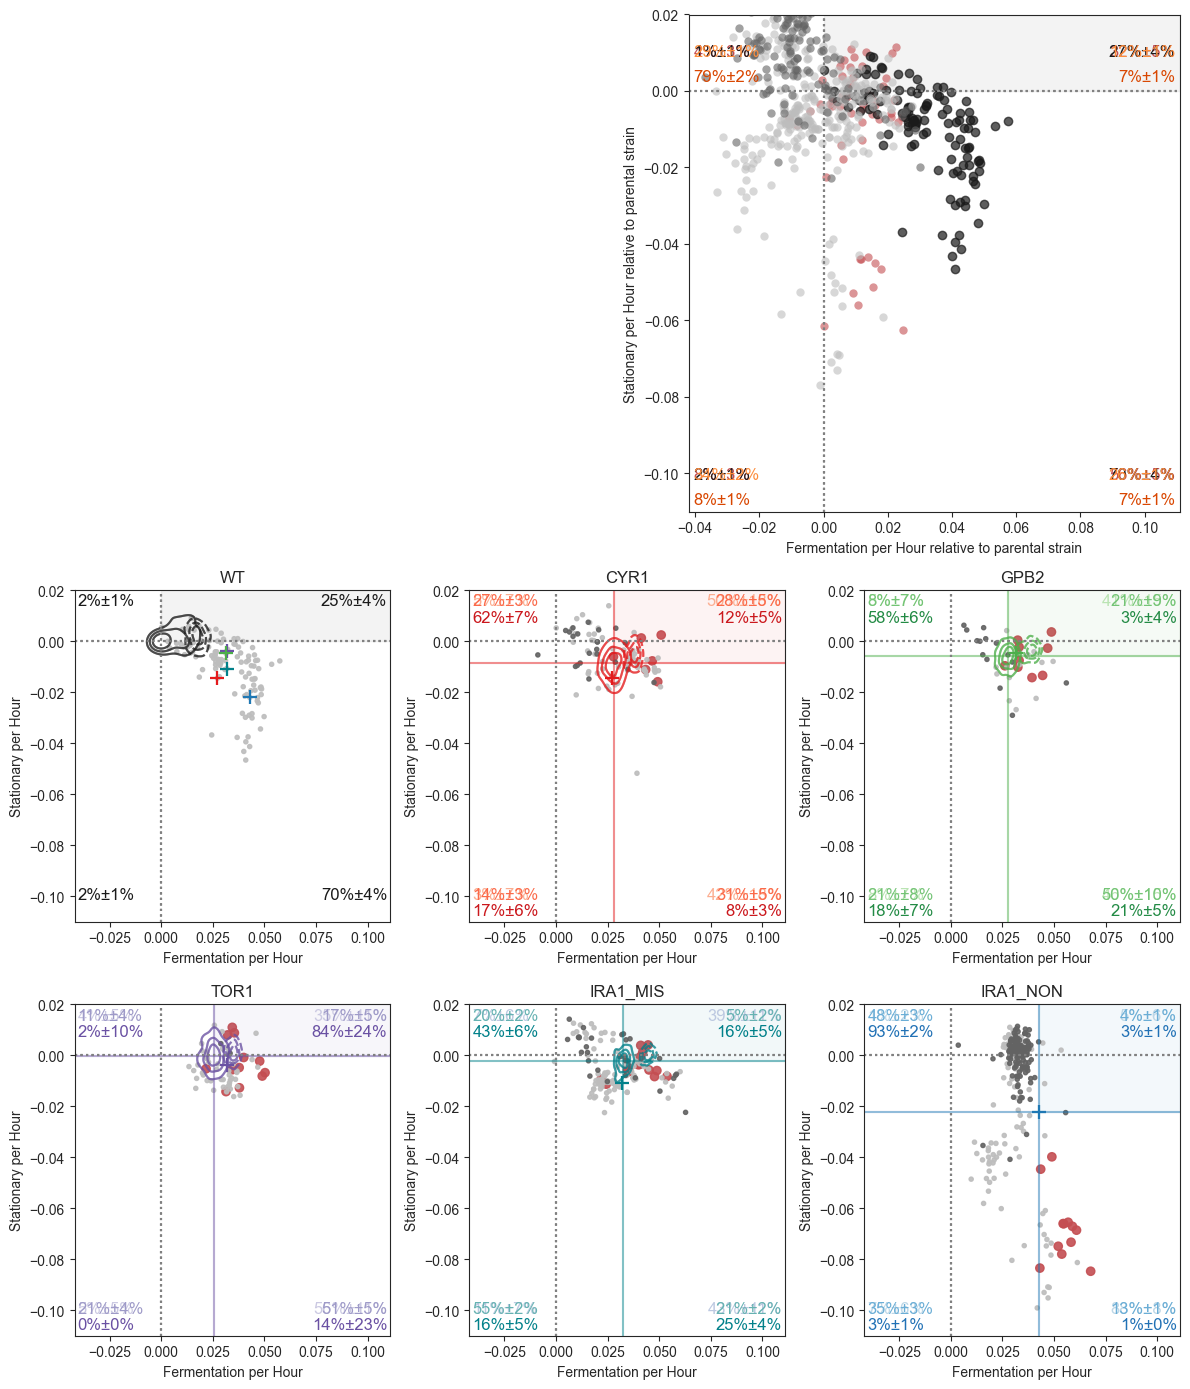

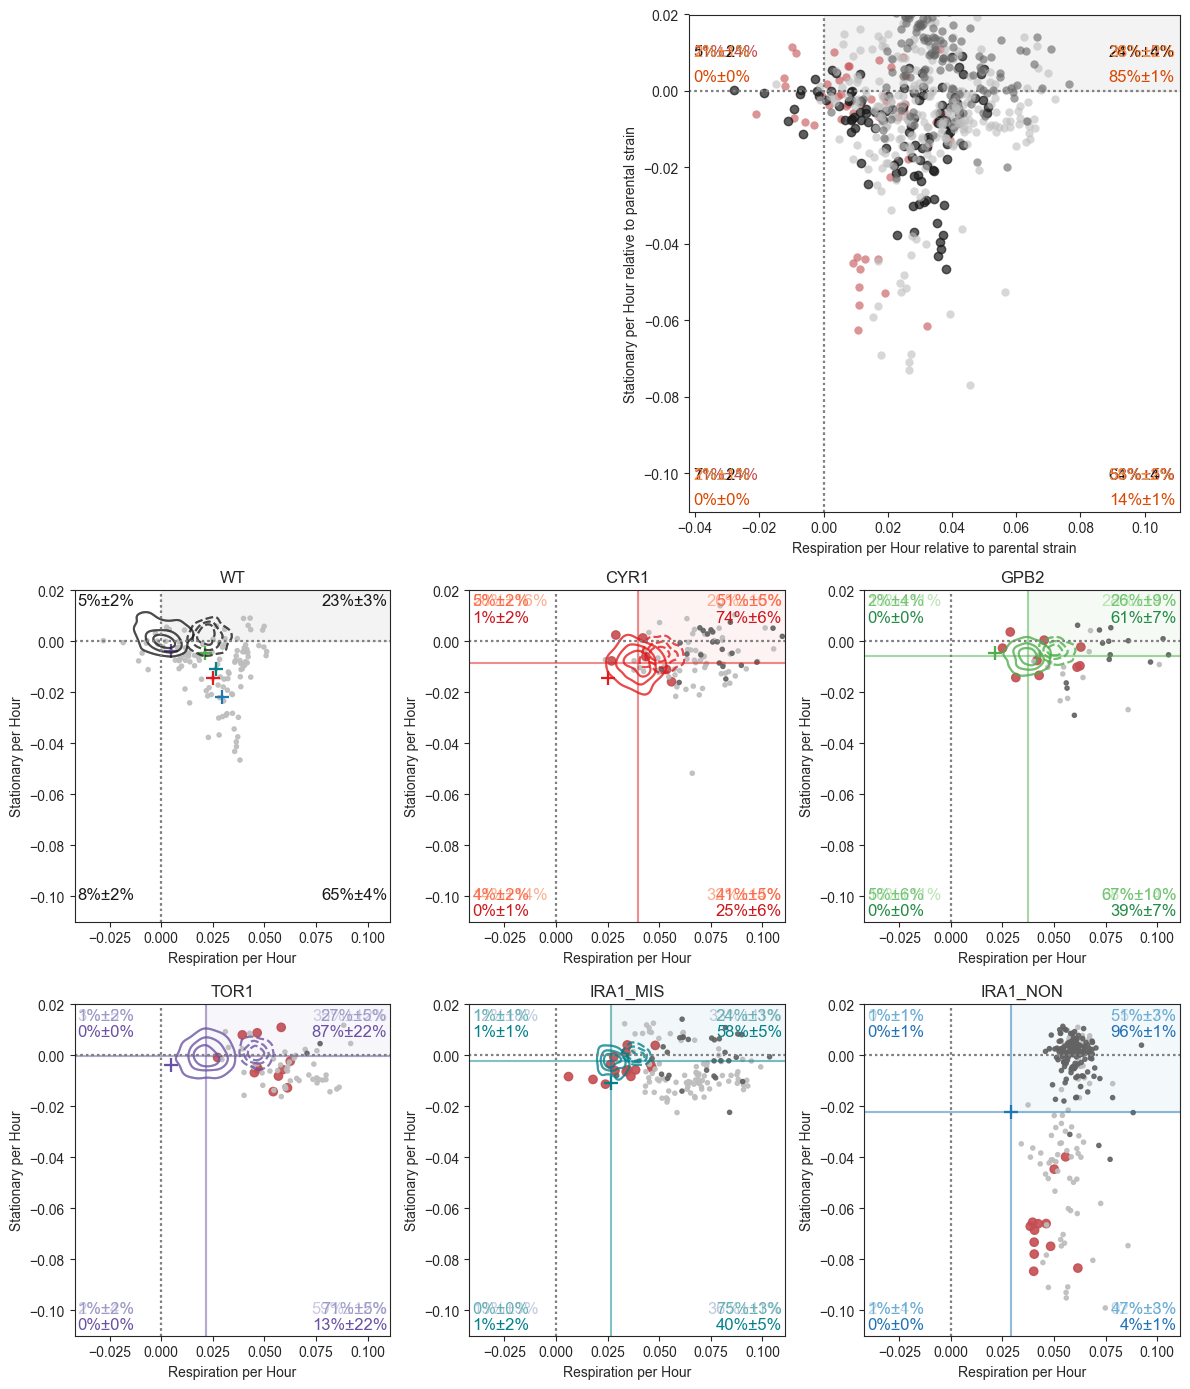

In [13]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}


va_dict = {0:'bottom',1:'center',2:'top'}
ha_dict = {0:'left',1:'center',2:'right'}
# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = [['Evo1D','Evo2D','Evo3D']]

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True
show_error = False
all_density = True

with_1day_colors = {'Evo1D':'r','Evo2D':'#bdbdbd','Evo3D':'#636363'}


### cutoff for standard deviation
multiplier = 2.0
# multiplier = 1.96
multiplier = 0.0 

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for evo_cond_set in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
#     for xdata,ydata in combinations(['Fit2D_early_fitness','Fit3D_early_fitness'],2):
    # publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
#         ancestor_list = [
        ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
#         ancestor_list = [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
        fig = plt.figure(figsize=(3*4,3.5*4))
        outer_gs = gridspec.GridSpec(2, 1,height_ratios=[2,3])
        
        # larger gridspec for First-step and all second-step mutants
        few_inner_gs = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec = outer_gs[0],wspace=0.25,hspace=0.25)

        # smaller grid spec for each individual set of second-step mutants
        many_inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
        
        for a,ancs in enumerate(ancestor_list):
            if len(ancs) > 1:
                fig.add_subplot(few_inner_gs[1]) 
                
                plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
                                                color='k',alpha=0.05)
                
#                 if all_density:
                    
            elif ancs[0] == 'WT':
                fig.add_subplot(many_inner_gs[a-1]) 
                
                plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
                                                color='k',alpha=0.05)
            else:
                fig.add_subplot(many_inner_gs[a-1]) 
            
            if len(ancs) == 1:
                if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
                    for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                        ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                        resps = (fitness-16*ferms)/28 # 2day = 16*F


    #                     norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
    #                             vmax=np.nanmax(merged_fitness[fitness_colorby]))
                        norm = matplotlib.colors.Normalize(vmin=0,
                                vmax=np.nanmax(merged_fitness[fitness_colorby]))



                        cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 

                        plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.1)
                        plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.15,ha='right',va='top')


            for evo_i,evo_cond in enumerate(evo_cond_set):
            
                this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

                these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
                these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

                interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
                
                interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                gray_alpha = 0.1
                bold_alpha = 0.5


                if len(ancs) > 1:
                
                    if all_density: 
                        if evo_cond == 'Evo2D':
                            
                            fill = True
#                             color = 'orange'
                            
#                             if len(evo_cond_set) == 1:
#                                 fill = False
                                
                            wt_data = noLi2019[(noLi2019['ancestor']=='WT') & 
                                               ~(noLi2019['class_new']=='pure_diploids') & 
                                               ~(noLi2019['class_new']=='neutral_haploids')]
#                                 sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond)
                            plt.scatter(wt_data[xdata+'_relative'].values,wt_data[ydata+'_relative'].values,
                                        color='k',alpha=0.7)
    
    
                            tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(wt_data[xdata+'_relative'].values,
                                                                      wt_data[ydata+'_relative'].values,
                                                                      wt_data[xdata+'_error'].values,
                                                                      wt_data[ydata+'_error'].values,
                                0,0,0,0,
                                multiplier=multiplier,use_both_errors=True,n_resamples=1000)
                            
        
                            ## annotate 
                            xy_set = [(0,2),(2,0),(2,2)]
                            
                            if ydata == 'StaPerHour':
                                xy_set.append((0,0))

                            for (x,y) in xy_set:
                                if x == 1:
                                    loc_x = (0-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                                elif x == 0:
                                    loc_x = x/2 + offset
                                else:
                                    loc_x = x/2 - offset

                                if y == 1:
                                    loc_y = (0-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                                elif y == 0:
                                    loc_y = y/2 + offset + 0.1 - y_offset
                                else:
                                    loc_y = y/2 - offset - y_offset
                                    
                                if not p.isnull(tradeoff_means[x][y]):
                                    plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
                                         x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
                                         ha=ha_dict[x],va=va_dict[y],color='k')


#                             sns.kdeplot(x=this_data[xdata+'_relative'].values,y=this_data[ydata+'_relative'].values,
#                                                     color='orange',fill=fill,thresh=0.1,levels=9,
#                                                     alpha=1.0,label=evo_cond)


                            
                            plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                        color=with_1day_colors[evo_cond],alpha=0.6,linewidths=0)
                        else:
#                             print('skipping plotting Evo3D')
                            plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                        color=with_1day_colors[evo_cond],alpha=0.6,linewidths=0)

#                             sns.kdeplot(x=this_data[xdata+'_relative'].values,y=this_data[xdata+'_relative'].values,
#                                                     color='b',fill=False,thresh=0.1,levels=9,
#                                                     alpha=1.0,label=evo_cond)
                #d95f0e
#                         plt.title('First Step vs. All Second Step')
#                         plt.xlabe
            
                    else:
                        if errorbar:
                            if show_error:
                                plt.errorbar(x=this_data[xdata+'_relative'].values,y=this_data[ydata+'_relative'].values,
                                             xerr=multiplier*this_data[xdata+'_error'].values,yerr=multiplier*this_data[ydata+'_error'].values,
                                         ms=0,linestyle='',elinewidth=0.05,
                                    alpha=alpha,c='k',
                                    marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

    #                         print(np.logical_and(~(this_data[xdata]-multiplier*this_data[xdata+'_error'].values > this_data[xdata+'_ancestor'].values),
    #                                               ~(this_data[xdata]+multiplier*this_data[xdata+'_error'].values < this_data[xdata+'_ancestor'].values)))

                            same = np.logical_or(np.logical_and(~(this_data[xdata]-multiplier*this_data[xdata+'_error'].values > this_data[xdata+'_ancestor'].values),
                                                  ~(this_data[xdata]+multiplier*this_data[xdata+'_error'].values < this_data[xdata+'_ancestor'].values)),
                                                 np.logical_and(~(this_data[ydata]-multiplier*this_data[ydata+'_error'].values > this_data[ydata+'_ancestor'].values),
                                                  ~(this_data[ydata]+multiplier*this_data[ydata+'_error'].values < this_data[ydata+'_ancestor'].values))
                                                )

                            sc = plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                    color=[with_1day_colors[evo_cond] if not same.values[a] else tools.anc_evo_cond_color_map[anc]['Evo1D'] for a,anc in enumerate(this_data['ancestor'].values) ],
                                    alpha=alpha,
                                    marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                        else:
                            sc = plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                    color=[tools.anc_evo_cond_color_map[anc][evo_cond] for anc in this_data['ancestor'].values],
                                    alpha=alpha,
                                    marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')




                else:
                    
                    for anc in ancs:

                        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                        sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                    color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                        sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                    color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
                    
                    
                    alpha = 0.9
#                     if len(evo_cond_set) > 1:
#                         if evo_cond == 'Evo2D':
#                             alpha = 0.2
# #                             elinewideth=0
                    

                    if errorbar:
                        if show_error:
                            plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                         xerr=multiplier*this_data[xdata+'_error'].values,yerr=multiplier*this_data[ydata+'_error'].values,
                                     ms=0,linestyle='',elinewidth=0.05,
                                alpha=alpha,c='k',
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                        
                        same = np.logical_or(np.logical_and(~(this_data[xdata]-multiplier*this_data[xdata+'_error'].values > this_data[xdata+'_ancestor'].values),
                                              ~(this_data[xdata]+multiplier*this_data[xdata+'_error'].values < this_data[xdata+'_ancestor'].values)),
                                             np.logical_and(~(this_data[ydata]-multiplier*this_data[ydata+'_error'].values > this_data[ydata+'_ancestor'].values),
                                              ~(this_data[ydata]+multiplier*this_data[ydata+'_error'].values < this_data[ydata+'_ancestor'].values)),
                                            )
                        
                        sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[with_1day_colors[evo_cond] if not same.values[a] else tools.anc_evo_cond_color_map[anc]['Evo1D'] for a,anc in enumerate(this_data['ancestor'].values) ],
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                    else:
                        sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[with_1day_colors[evo_cond] for anc in this_data['ancestor'].values],
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

#                     plt.legend(loc='lower left',fontsize='small')
                    plt.title(f'{ancs[0]}')

                for anc in ancs:
                    
                    if len(ancs) < 2:
                        if anc != 'WT':

                            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                        marker='+',color=tools.anc_color_map[anc],s=100)

    #                         plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
    #                                                 color=tools.anc_color_map[anc],alpha=0.02)

                    if len(ancs) < 2:

                        if anc != 'IRA1_NON':

#                             x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                            x_mean = np.nanmedian(this_neutral_haploid[xdata].values)
                            x_error = np.nanstd(this_neutral_haploid[xdata].values)/len(this_neutral_haploid[xdata].values)
#                             y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                            y_mean = np.nanmedian(this_neutral_haploid[ydata].values)
                            y_error = np.nanstd(this_neutral_haploid[ydata].values)/len(this_neutral_haploid[ydata].values)
                            
                            if anc != 'WT':
                                plt.axvline(x_mean,color=tools.anc_color_map[anc],alpha=0.2)
                                plt.axhline(y_mean,color=tools.anc_color_map[anc],alpha=0.2)
                                
                                if evo_i == 0:
                                    plt.fill_between([x_mean,tools.lims[xdata][1]],y_mean,tools.lims[ydata][1],
                                                color=tools.anc_color_map[anc],alpha=0.05)


                            tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata].values,
                                                                      interesting_muts[ydata].values,
                                                                      interesting_muts[xdata+'_error'].values,
                                                                      interesting_muts[ydata+'_error'].values,
                                x_mean,y_mean,
                                x_error,y_error,
                                multiplier=multiplier,use_both_errors=True,n_resamples=1000)
                            
                            if anc == 'WT':
                                for anc2 in tools.rebarcoding_source_mutants.keys():
                                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc2],s=100)

                        else:
#                             print('error',anc,ydata,background_mutant[ydata+'_error'].values,background_mutant[ydata+'_error'].values/len(background_mutant[ydata+'_error'].values))

                            plt.axvline(background_mutant[xdata].values,
                                      color=tools.anc_color_map[anc],alpha=0.2)
    
                            plt.axhline(background_mutant[ydata].values,
                                      color=tools.anc_color_map[anc],alpha=0.2)
        
                            tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata].values,
                                                                      interesting_muts[ydata].values,
                                                                      interesting_muts[xdata+'_error'].values,
                                                                      interesting_muts[ydata+'_error'].values,
                                background_mutant[xdata].values[0],background_mutant[ydata].values[0],
                                0,0,
                                multiplier=multiplier,use_both_errors=True,n_resamples=1000)
                            
                            if evo_i == 0:
                                plt.fill_between([background_mutant[xdata].values[0],tools.lims[xdata][1]],background_mutant[ydata].values[0],tools.lims[ydata][1],
                                                color=tools.anc_color_map[anc],alpha=0.05)
                        
                        
                        va_dict = {0:'bottom',1:'center',2:'top'}
                        ha_dict = {0:'left',1:'center',2:'right'}

                        offset = 0.01
                        y_offset = 0.0
                        if len(evo_cond_set) > 1:
                            if evo_cond == 'Evo3D':
                                y_offset = 0.05
                            
            
                        xy_set = [(0,2),(2,0),(2,2)]
                            
                        if ydata == 'StaPerHour':
                            xy_set.append((0,0))
                        
                        for (x,y) in xy_set:
                            if x == 1:
                                loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                            elif x == 0:
                                loc_x = x/2 + offset
                            else:
                                loc_x = x/2 - offset

                            if y == 1:
                                loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                            elif y == 0:
                                loc_y = y/2 + offset + 0.05 - y_offset
                            else:
                                loc_y = y/2 - offset - y_offset
                            if not p.isnull(tradeoff_means[x][y]):
                                plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
                                         x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
                                         ha=ha_dict[x],va=va_dict[y],color=tools.anc_evo_cond_color_map[anc][evo_cond])
                            

                    elif ancs[0] == 'WT':
                        
                        for anc2 in tools.rebarcoding_source_mutants.keys():
                            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc2],s=100)

                if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                    plt.plot(levy_pareto_line[0],levy_pareto_line[1],color='k',lw=1,zorder=0)

                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
                
                if len(ancs) > 1:
                    
                    tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,
                                                                      interesting_muts[ydata+'_relative'].values,
                                                                      interesting_muts[xdata+'_error'].values,
                                                                      interesting_muts[ydata+'_error'].values,
                                0,0,0,0,
                                multiplier=multiplier,use_both_errors=True,n_resamples=1000)
                    
                    xy_set = [(0,2),(2,0),(2,2)]
                    
                    offset = 0.01
                    y_offset = 0.05
                    if len(evo_cond_set) > 1:
                        if evo_cond == 'Evo3D':
                            y_offset = 2*0.05
                            
                    if ydata == 'StaPerHour':
                        xy_set.append((0,0))

                    for (x,y) in xy_set:
                        if x == 1:
                            loc_x = (0-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset

                        if y == 1:
                            loc_y = (0-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset + 0.1 - y_offset
                        else:
                            loc_y = y/2 - offset - y_offset
                        
                        show_tradeoffs = True
#                         this_color = 'orange'
#                         if len(evo_cond_set) > 1:
#                             if evo_cond == 'Evo3D':
#                                 this_color='b'
#                                 show_tradeoffs = False
                                
                        
                        if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
                            plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
                                     ha=ha_dict[x],va=va_dict[y],color=tools.anc_evo_cond_color_map['all_second_step'][evo_cond])

                    
                    plt.xlabel(f'{labels[xdata]} relative to parental strain')
                    plt.ylabel(f'{labels[ydata]} relative to parental strain')
                    
                else:
                    plt.xlabel(labels[xdata])
                    plt.ylabel(labels[ydata])

                plt.axvline(0,color='gray',linestyle=':')
                plt.axhline(0,color='gray',linestyle=':')


        plt.tight_layout()
        if not errorbar:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/Evo1D_tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/Evo1D_tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only.png',bbox_inches='tight',dpi=300)
        else:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/Evo1D_tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only_errorbar_{multiplier}.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/Evo1D_tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only_errorbar_{multiplier}.png',bbox_inches='tight',dpi=300)


In [145]:
multiplier = 2
innovation_list = {}

total_tradeoffs_dict = {}
tradeoffs_dict = {}

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    for anc in ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
        
    
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        total_tradeoffs = count_tradeoffs(interesting_muts[xdata+'_relative'].values,interesting_muts[ydata+'_relative'].values,
                                          interesting_muts[xdata+'_error'].values,interesting_muts[ydata+'_error'].values,
                             0,0,0,0,
                            multiplier=multiplier,use_both_errors=True)
        
        innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]
        
        
        print(anc,total_tradeoffs[:-1])
        for evo_set in [['Evo2D'],['Evo3D']]:

            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]
            

            tradeoffs = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,interesting_muts[ydata+'_relative'].values,
                                          interesting_muts[xdata+'_error'].values,interesting_muts[ydata+'_error'].values,
                             0,0,0,0,
                            multiplier=multiplier,use_both_errors=True)
                
            tradeoffs_dict[f'{xdata}_{ydata}'][f'{anc}_{evo_set[0]}'] = np.asarray(tradeoffs)
            
            if anc != 'WT':
                if evo_set[0] not in total_tradeoffs_dict[f'{xdata}_{ydata}'].keys():
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs)
                else:
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs)
            
                print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])
            
            
            
#             total_tradeoffs += tradeoffs 

            print(anc,evo_set,tradeoffs[:-1])

# print('Improved Both')
# for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
#     for evo_cond in ['Evo2D','Evo3D']:
#         print(xdata,ydata,evo_cond,'improved both:',
#               f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
#               total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
#              )
        
# print('improved respiration')
# resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
# all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
# print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
# print('improved respiration')
# resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
# all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
# print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)



FerPerHour ResPerHour
WT ([[0, 0, 0], [0, 14, 3], [0, 33, 69]], 119)
WT ['Evo2D'] (array([[0.01453782, 0.        , 0.01512605],
       [0.        , 0.        , 0.        ],
       [0.10848739, 0.        , 0.86184874]]),)
WT ['Evo3D'] (array([[0.01159664, 0.        , 0.01781513],
       [0.        , 0.        , 0.        ],
       [0.10319328, 0.        , 0.86739496]]),)
CYR1 ([[0, 0, 22], [0, 15, 22], [0, 13, 18]], 90)
CYR1 ['Evo2D'] (array([[0.01055556, 0.        , 0.48422222],
       [0.        , 0.        , 0.        ],
       [0.07155556, 0.        , 0.43366667]]), array([[0.01034885, 0.        , 0.02672124],
       [0.        , 0.        , 0.        ],
       [0.01827904, 0.        , 0.03263926]])) [[[0.01055556 0.         0.48422222]
  [0.         0.         0.        ]
  [0.07155556 0.         0.43366667]]

 [[0.01034885 0.         0.02672124]
  [0.         0.         0.        ]
  [0.01827904 0.         0.03263926]]]
CYR1 ['Evo2D'] (array([[0.01055556, 0.        , 0.48422222],


TOR1 ['Evo2D'] (array([[0.01583333, 0.        , 0.01783333],
       [0.        , 0.        , 0.        ],
       [0.67683333, 0.        , 0.2895    ]]), array([[0.01721998, 0.        , 0.01585612],
       [0.        , 0.        , 0.        ],
       [0.04719316, 0.        , 0.04664613]])) [[[0.10422222 0.         0.12222222]
  [0.         0.         0.        ]
  [1.51138889 0.         1.26216667]]

 [[0.06814253 0.         0.0699106 ]
  [0.         0.         0.        ]
  [0.13893116 0.         0.132349  ]]]
TOR1 ['Evo2D'] (array([[0.01583333, 0.        , 0.01783333],
       [0.        , 0.        , 0.        ],
       [0.67683333, 0.        , 0.2895    ]]),)
TOR1 ['Evo3D'] (array([[0.015     , 0.        , 0.01583333],
       [0.        , 0.        , 0.        ],
       [0.685     , 0.        , 0.28416667]]), array([[0.01589899, 0.        , 0.0147902 ],
       [0.        , 0.        , 0.        ],
       [0.04265495, 0.        , 0.04380354]])) [[[0.10344444 0.         0.12233333]
  [

In [172]:
tradeoffs

array([0.01336134, 0.        , 0.01613445])

In [148]:
here_here = total_tradeoffs_dict[f'FerPerHour_StaPerHour']['Evo2D']

print(here_here,np.sum(here_here))

print('Stationary down',np.sum(here_here[:,0]),np.sum(here_here[:,0])/np.sum(here_here))
print('Stationary same',np.sum(here_here[:,1]),np.sum(here_here[:,1])/np.sum(here_here))
print('Stationary up',np.sum(here_here[:,2]),np.sum(here_here[:,1])/np.sum(here_here))

print('Ferm up',np.sum(here_here[2,:]),np.sum(here_here[:,1])/np.sum(here_here))

here_here = total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D']

[[[1.05921223 0.         1.66588428]
  [0.         0.         0.        ]
  [1.45083541 0.         0.82406808]]

 [[0.14665113 0.         0.13137321]
  [0.         0.         0.        ]
  [0.16434204 0.         0.16393987]]] 5.606306249536719
Stationary down 3.003120850797121 0.5356683557993797
Stationary same 0.0 0.0
Stationary up 2.603185398739597 0.0


IndexError: index 2 is out of bounds for axis 0 with size 2

In [149]:
here_here = total_tradeoffs_dict[f'FerPerHour_StaPerHour']['Evo2D']

print(here_here,np.sum(here_here))

print('Stationary down',np.sum(here_here[:,0]),np.sum(here_here[:,0])/np.sum(here_here))
print('Stationary same',np.sum(here_here[:,1]),np.sum(here_here[:,1])/np.sum(here_here))
print('Stationary up',np.sum(here_here[:,2]),np.sum(here_here[:,1])/np.sum(here_here))

print('Ferm up',np.sum(here_here[2,:]),np.sum(here_here[:,1])/np.sum(here_here))

[[[1.05921223 0.         1.66588428]
  [0.         0.         0.        ]
  [1.45083541 0.         0.82406808]]

 [[0.14665113 0.         0.13137321]
  [0.         0.         0.        ]
  [0.16434204 0.         0.16393987]]] 5.606306249536719
Stationary down 3.003120850797121 0.5356683557993797
Stationary same 0.0 0.0
Stationary up 2.603185398739597 0.0


IndexError: index 2 is out of bounds for axis 0 with size 2

In [77]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [99]:
[this_data[xdata].values-background_x,this_data[ydata].values-background_y]

[array([0.00303167, 0.00752625]), array([0.05506493, 0.04873356])]

In [150]:
xdata = 'FerPerHour'
ydata = 'ResPerHour'
this_anc = noLi2019[noLi2019['ancestor'].isin(['WT'])]

these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

wt_tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,0,0,
                                 0,0,0,0,
                                multiplier=multiplier)

In [151]:
wt_tradeoffs

[[0, 0, 0], [0, 0, 0], [10, 0, 109]]

In [15]:

for multiplier in [0,1]:
    print(f'Multiplier = {multiplier}')
    total_tradeoffs_dict = {}

    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        print(xdata,ydata)

        innovation_list[f'{xdata}_{ydata}'] = {}
        total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}


        for anc in ancestor_list[0][1:]:

            this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
            this_neutral_haploid = this_anc[this_anc['barcode'].isin(list(these_neutral_haploids))]
            
            if anc != 'IRA1_NON':
            
                x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                x_error = np.nanstd(this_neutral_haploid[xdata].values)
                y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                y_error = np.nanstd(this_neutral_haploid[ydata].values)
                
            else:
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
                x_mean = background_mutant[xdata].values
                x_error = background_mutant[xdata+'_error'].values
                y_mean = background_mutant[ydata].values
                y_error = background_mutant[ydata+'_error'].values

            total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,
                                            interesting_muts[ydata].values,0,0
                                            x_mean,y_mean,
                                            x_error,y_error,
                                            multiplier=multiplier)


            innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]

            print(anc,total_tradeoffs[:-1])
            for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

                this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

                tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

                if anc == 'CYR1':
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
                else:
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])


                print(anc,evo_set,tradeoffs[:-1])

    print('Improved Both')
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        for evo_cond in ['Evo1D','Evo2D','Evo3D']:
            print(xdata,ydata,evo_cond,'improved both:',
                  f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
                  total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
                 )

    print('improved respiration')
    resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
    all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
    print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
    print('improved respiration at cost of fermentation')
    resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
    all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
    print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)


Multiplier = 0
FerPerHour ResPerHour


TypeError: count_tradeoffs() missing 2 required positional arguments: 'background_error_x' and 'background_error_y'

In [69]:
merged_fitness[merged_fitness['barcode'].isin(innovation_list['FerPerHour_ResPerHour'])][['barcode','gene','ancestor','evolution_condition','class_new','all_mutations_verbose']].to_csv(f'{home_dir}/data/intermediate/innovators_FerRes.csv')

['WT'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo3D


/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_2187/672533896.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


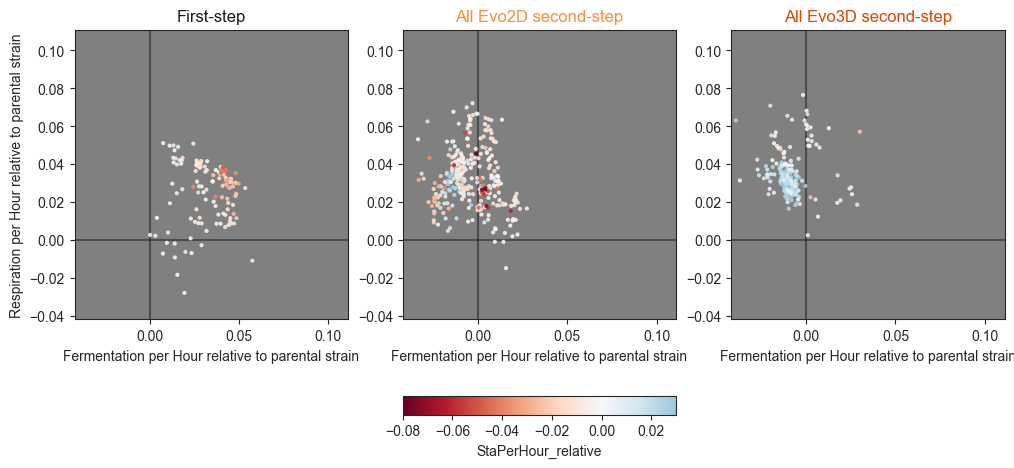

In [143]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour relative to parental strain','ResPerHour':'Respiration per Hour relative to parental strain','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour_relative'

errorbar = False

# cutoff for standard deviation
multiplier = 1.0

# innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

names = ['First-step','All Evo2D second-step','All Evo3D second-step']

ancestor_evo_list = [(['WT'],'Evo2D'),
                         (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo2D'),
                        (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo3D')]

# ancestor_evo_list = [(['WT'],'Evo2D'),
#                          (['CYR1','GPB2','TOR1','IRA1_MIS'],'Evo2D'),
#                         (['CYR1','GPB2','TOR1','IRA1_MIS'],'Evo3D')]
for xdata,ydata in combinations(['FerPerHour','ResPerHour'],2):
    
    fig = plt.figure(figsize=(12,5))
    outer_gs = gridspec.GridSpec(2,1,height_ratios=[4,0.25],hspace=0.5)
    inner_gs = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0])
    bottom_gs = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[1])

    for a,anc_evo in enumerate(ancestor_evo_list):
        
        ancs = anc_evo[0]
        evo_cond = anc_evo[1]
        
        print(ancs,evo_cond)

        this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

#         plt.add_subplot()
        
        fig.add_subplot(inner_gs[a])
        plt.gca().set_facecolor('gray')
#         plt.gca().set_facecolor('k')

        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]

        normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(noLi2019[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(noLi2019[fitness_colorby]).max())
        
        sorting_order = np.argsort(this_data[fitness_colorby].values)[::-1]
#         sorting_order = np.argsort(this_data[fitness_colorby].values)

        sc = plt.scatter(this_data[xdata+'_relative'].values[sorting_order],
                         this_data[ydata+'_relative'].values[sorting_order],
                            c=this_data[fitness_colorby].values[sorting_order],cmap='RdBu',
                            norm=normalize,
                            marker='.',
                            alpha=0.9,linewidths=0)

        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        

        plt.axvline(0,color='k',linestyle='-',alpha=0.5,zorder=0)
        plt.axhline(0,color='k',linestyle='-',alpha=0.5,zorder=0)
        
        if len(ancs) > 1:
            plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['all_second_step'][evo_cond]})
        else:
            plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['WT'][evo_cond]})
            plt.ylabel(labels[ydata])
        
    if a == 2:
        plt.subplot(bottom_gs[1])
#         plt.gca().set_visible(False)
        cmap = plt.get_cmap('RdBu')

        vmin = np.round(np.nanmin(noLi2019[fitness_colorby]),2)
        vmax = np.round(np.nanmax(noLi2019[fitness_colorby]),2)

        norm2 = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)

        total_len = 2*np.abs([vmin,vmax]).max()

        if np.abs(vmin) > np.abs(vmax):
            these_colors = cmap(np.linspace(0,(vmax-vmin)/total_len, cmap.N))
        else:
            these_colors = cmap(np.linspace(1.-(vmax-vmin)/total_len, 1, cmap.N))
        # these_colors = cmap(np.linspace(0,total_len, cmap.N))

        color_map = matplotlib.colors.LinearSegmentedColormap.from_list('RdBu', these_colors)

        # create some axes to put the colorbar to
        cax = plt.subplot(bottom_gs[1])
        cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm2,
                                                orientation='horizontal')

        cbar.set_label(fitness_colorby)
#         plt.axis('off')
        


    plt.tight_layout()
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_AllSecond_stationary_color.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_AllSecond_stationary_color.png',bbox_inches='tight',dpi=300)

In [ ]:
# colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
evo_cond_list = ['Evo2D','Evo3D']

centroids = False
pathways = True
annotate = False

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT'],['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])
    few_inner_gs = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec = outer_gs[0],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        many_inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        this_anc = this_anc[this_anc['evolution_condition'].isin(evo_cond_list)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        
        if len(ancs) > 1:
            fig.add_subplot(few_inner_gs[1]) 
            
        elif ancs[0] == 'WT':
            fig.add_subplot(few_inner_gs[0]) 
            
        else:
            fig.add_subplot(many_inner_gs[a-1])

            for anc in ancs:
                if anc != 'WT':
                    this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                    sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                    this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                    sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for ploidy,ploidy_list in {'haploid':['Haploid','haploid',np.nan,'?','NotSequenced','other'],'diploid':['diploid','Diploid']}.items():
#         for evo_cond in evo_cond_list:

            gene_list = {}
#             doubles_list = []

            this_data = interesting_muts[interesting_muts['ploidy_new'].isin(ploidy_list)]
            gray_alpha = 0.1
            if centroids:
                bold_alpha = 0.3
            else:
                bold_alpha = 0.7
#             if len(ancs) < 2:
            if True:
                colors = []
                annotation_list = []
                for e,gene in enumerate(this_data['gene'].values):
                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    already_assigned = False
                    if (not p.isnull(gene)) and (gene != 'NotSequenced'):
                        if gene in tools.mutation_color_map.keys():
                            if pathways:
                                color_assigned = matplotlib.colors.to_rgba(tools.find_pathway_color(gene),bold_alpha)
                            else:
                                color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map[gene],bold_alpha)
                            
                            if gene in gene_list.keys():
                                gene_list[gene].append(e)
                            else:
                                gene_list[gene] = [e]
                        elif '+' in gene:
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map['double_mutant'],bold_alpha)
                            
                            if anc != 'WT':
                                if this_data['barcode'].values[e] in innovation_list[f'{xdata}_{ydata}'][f'{anc}']:
                                    annotation_list.append([e,gene])
#                                 else:
#                                     annotation_list.append([e,gene])
#                             if gene in gene_list.keys():
#                                 gene_list[gene].append(e)
#                             else:
#                                 gene_list[gene] = [e]
                        else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    colors.append(color_assigned)
            else:
                colors = [tools.color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

            if len(ancs) > 1:
#                 alpha = 0.5
                
#                 background_x_dict = {anc:merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]][xdata].values[0] for anc in anc_list}
#                 background_y_dict = {anc:merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]][ydata].values[0] for anc in anc_list}

#                 background_x = [np.nanmean(this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')][xdata].values) if anc != 'IRA1_NON' else background_x_dict[anc] for anc in this_data['ancestor'].values]
#                 background_y = [np.nanmean(this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')][ydata].values) if anc != 'IRA1_NON' else background_y_dict[anc] for anc in this_data['ancestor'].values]

#                 plt.scatter(this_data[xdata].values-background_x,this_data[ydata].values-background_y,linewidths=0,
#                             color=colors,marker=tools.ploidy_marker_map[ploidy])
                plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,linewidths=0,
                            color=colors,marker=tools.ploidy_marker_map[ploidy])
               
                
            else:
                
                if centroids:
                    alpha = 0.3
                else:
                    alpha = 0.7
#                 plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             color=colors,marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
                plt.scatter(this_data[xdata].values,this_data[ydata].values,linewidths=0,
                            color=colors,marker=tools.ploidy_marker_map[ploidy],s=15,label=f'{ancs[0]} {ploidy}')
        
                if centroids:
                    for gene,e_list in gene_list.items():

                        gene_centroid = tools.centroid(this_data[[xdata,ydata]].values[e_list,:])

                        plt.scatter(gene_centroid[0],gene_centroid[1],
                                color=colors[e_list[0]],edgecolors='k',linewidth=0.5,
                                    marker=tools.ploidy_marker_map[ploidy],s=40,alpha=0.9)
                
    
                for e,doubles in annotation_list:
                    if annotate:
                        plt.annotate(text=doubles.replace('+','+\n'),xy=(this_data[xdata].values[e],this_data[ydata].values[e]),
                                 xytext=(this_data[xdata].values[e]+0.001,this_data[ydata].values[e]+0.001),
                                 color='k',fontsize=8)
                    plt.scatter(this_data[xdata].values[e],this_data[ydata].values[e],
                                marker=tools.ploidy_marker_map[ploidy],
                                color='k',s=15,alpha=0.5,linewidth=0.2)

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
                    
#         if xdata == 'FerPerHour' and ydata == 'ResPerHour':
#             plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

#         for anc in ancs:
        if len(ancs) < 2:
            for anc in ancs:
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)


                if anc != 'IRA1_NON':

                    x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                    x_error = np.nanstd(this_neutral_haploid[xdata].values)
                    y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                    y_error = np.nanstd(this_neutral_haploid[ydata].values)

                    plt.axvline(x_mean,color=tools.anc_color_map[anc],alpha=0.2)
    #                 plt.axvspan(x_mean-multiplier*x_error,
    #                           x_mean+multiplier*x_error,
    #                           color=tools.anc_color_map[anc],alpha=0.05)

                    plt.axhline(y_mean,color=tools.anc_color_map[anc],alpha=0.2)
    #                 plt.axhspan(y_mean-multiplier*y_error,
    #                           y_mean+multiplier*y_error,
    #                           color=tools.anc_color_map[anc],alpha=0.05)

                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,
                                                              interesting_muts[ydata].values,
                                                              interesting_muts[xdata+'_error'].values,
                                                              interesting_muts[ydata+'_error'].values,
                        x_mean,y_mean,
                        x_error,y_error,
                        multiplier=multiplier)

                else:
                    plt.axvline(background_mutant[xdata].values,color=tools.anc_color_map[anc],alpha=0.2)
    #                 plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
    #                           background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
    #                           color=tools.anc_color_map[anc],alpha=0.05)

                    plt.axhline(background_mutant[ydata].values,color=tools.anc_color_map[anc],alpha=0.2)
    #                 plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
    #                           background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
    #                           color=tools.anc_color_map[anc],alpha=0.05)

                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                                              interesting_muts[xdata+'_error'].values,interesting_muts[ydata+'_error'].values,
                         background_mutant[xdata].values,background_mutant[ydata].values,
                        background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                        multiplier=multiplier)

    #             if anc!='WT'


        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        
        if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
            for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                resps = (fitness-16*ferms)/28 # 2day = 16*F
                
                
                norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                        vmax=np.nanmax(merged_fitness[fitness_colorby]))

                cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 
                
                plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
                plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')
            
        
        
        if len(ancs) > 1:
            if pathways:
                pathway_labels = []
                for g,gene in enumerate(tools.mutation_color_map.keys()):
                    if gene in tools.pathway_gene_map.keys():
                        pathway_labels.append(tools.pathway_gene_map[gene])
                    else:
                        pathway_labels.append(gene)
                
#                 for p,pathway in enumerate(pathway_labels):
#                     plt.text(y=0.4-0.02*(p%(len(pathway_labels))/2)),x=0.01+0.1*int(p/len(pathway_labels)*2),s=f'{gene}',color=tools.find_pathway_color[pathway],transform=plt.gca().transAxes)

            else:
                for g,gene in enumerate(tools.mutation_color_map.keys()):
                    plt.text(y=0.4-0.02*(g%(len(tools.mutation_color_map.keys())/2)),x=0.01+0.1*int(g/len(tools.mutation_color_map.keys())*2),s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
    
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_{"pathway" if pathways else "mutation"}_colors{"_centroids" if centroids else ""}{"_annotatedInnovations" if annotate else ""}.pdf',bbox_inches='tight')
#         else:
#             plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_pathway_colors_centroids_annotatedInnovations.pdf',bbox_inches='tight')
#     elif not pathways:
#         plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_annotatedInnovations.pdf',bbox_inches='tight')
#     else:
#         plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_pathway_colors_annotatedInnovations.pdf',bbox_inches='tight')  
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_centroids_annotatedInnovations.pdf',bbox_inches='tight')


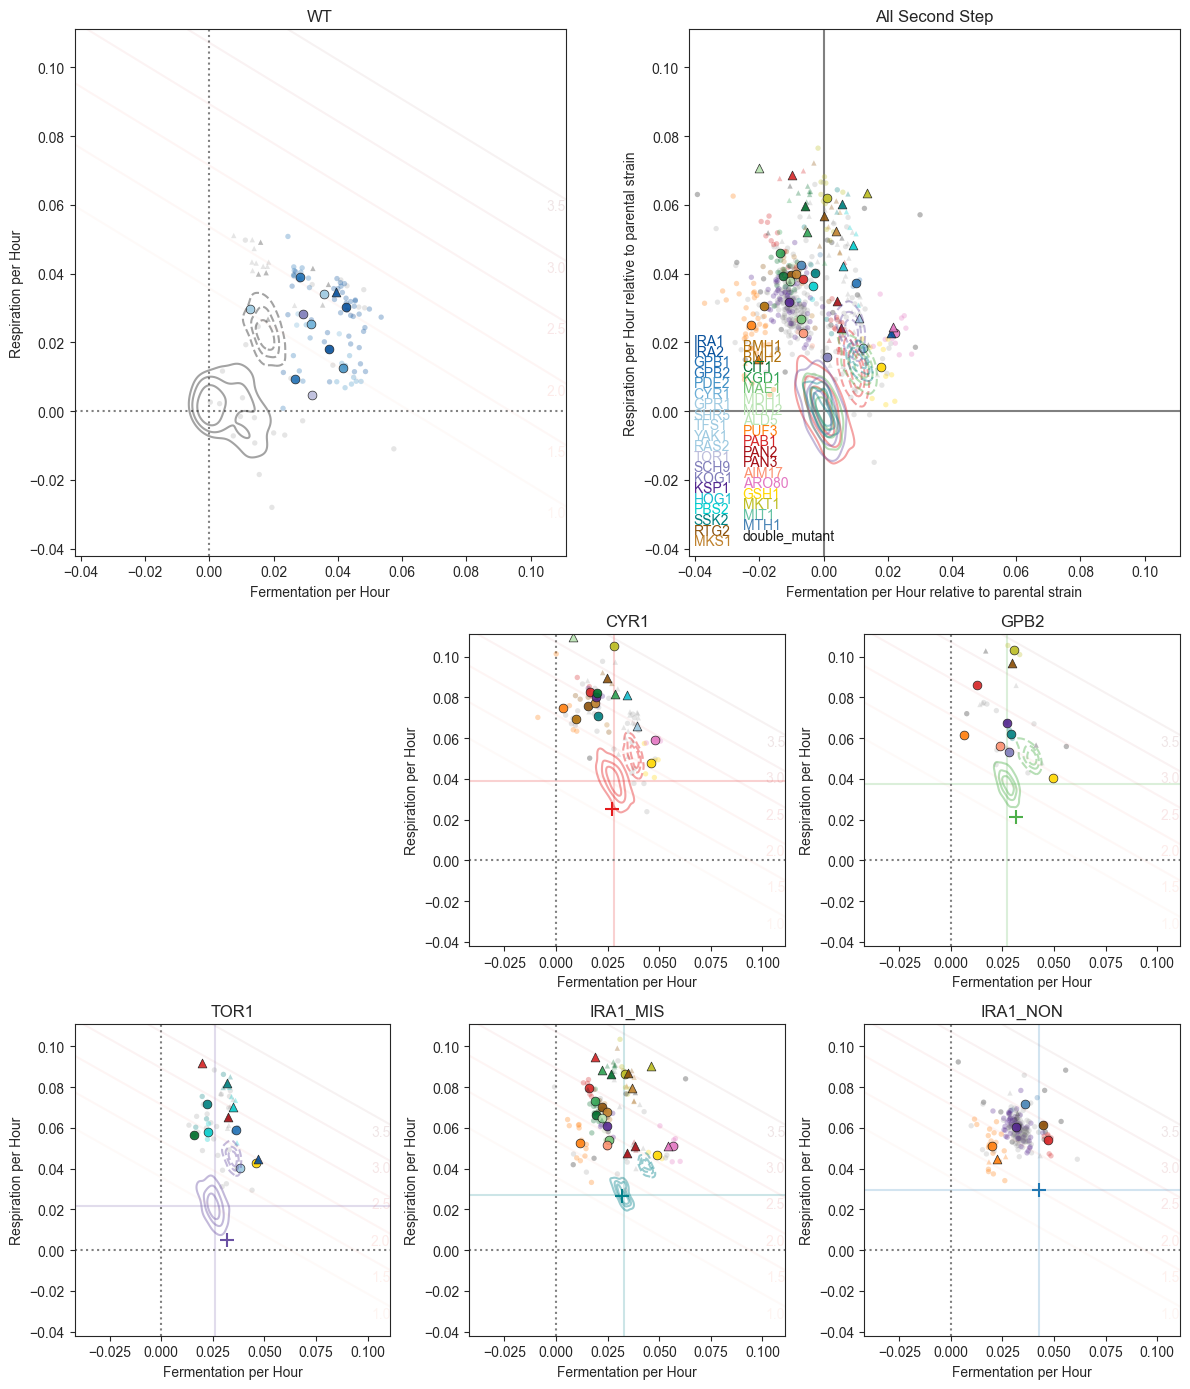

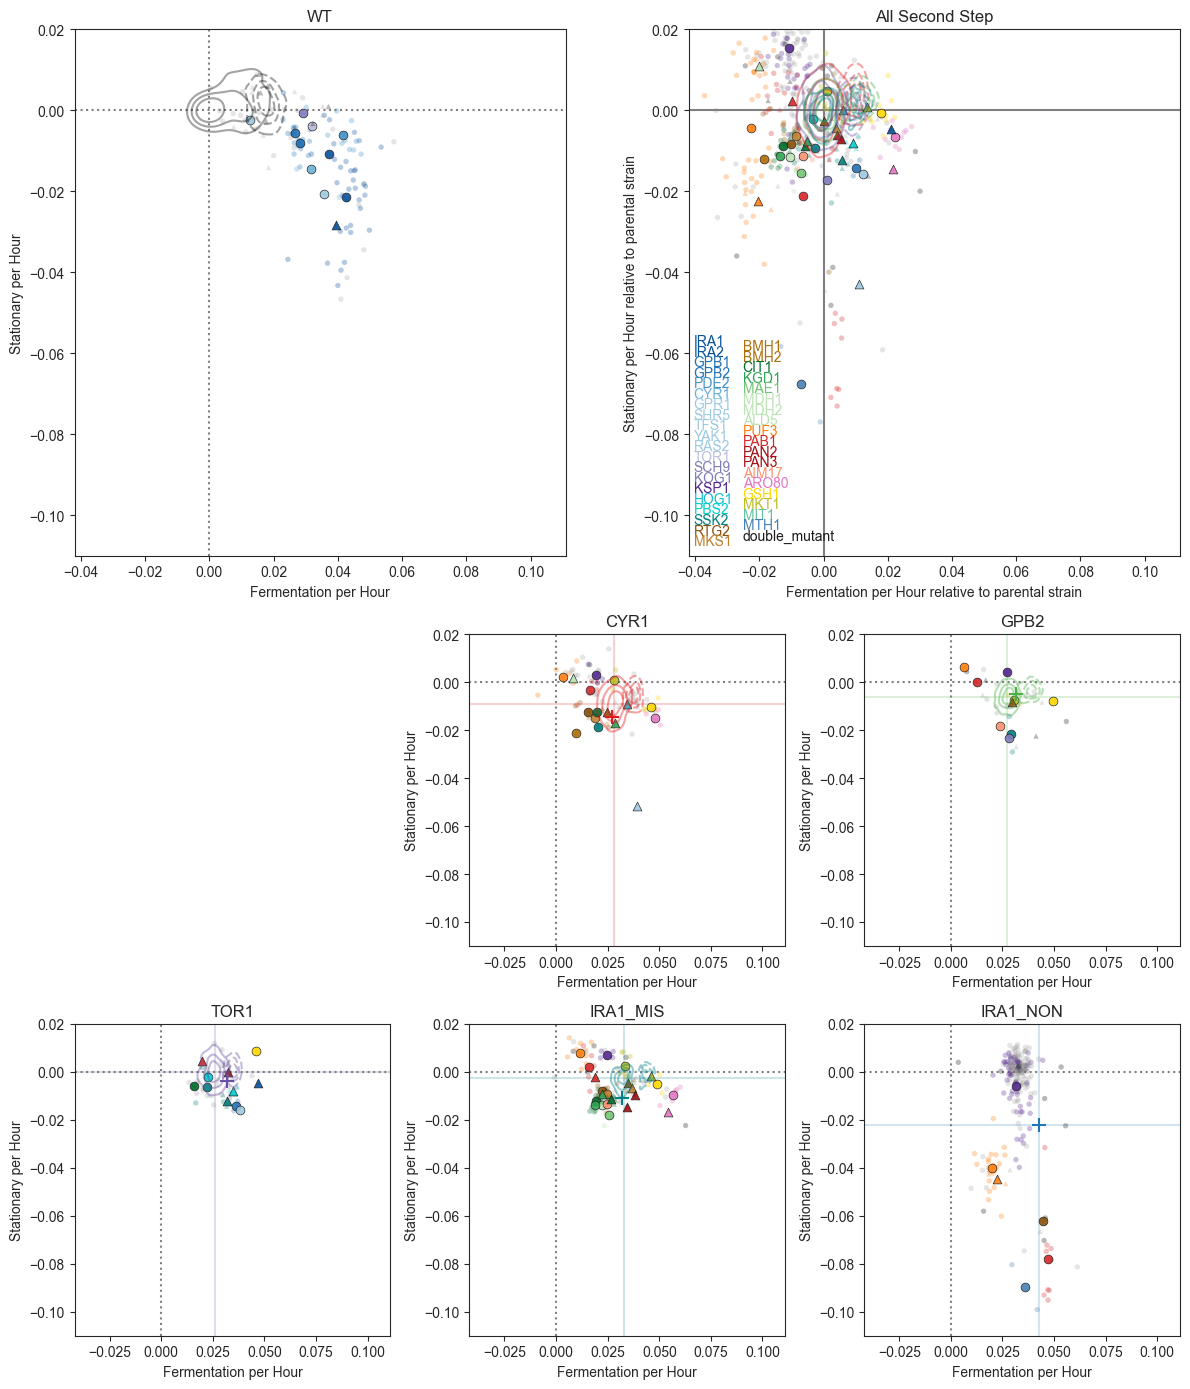

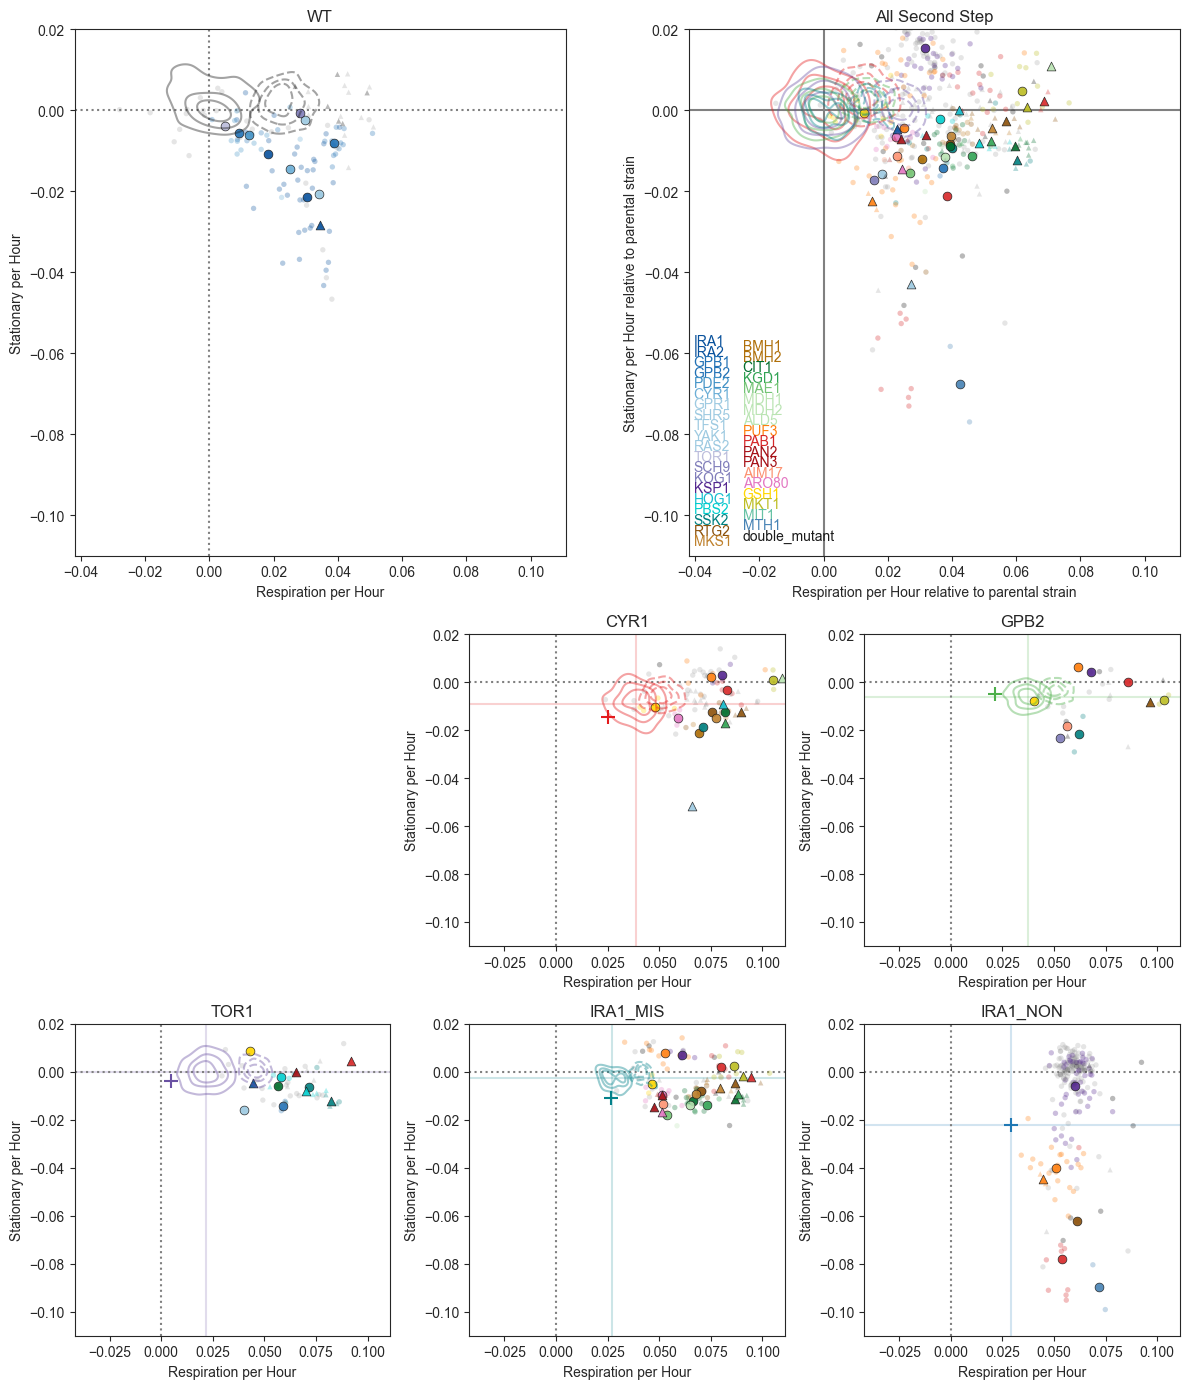

In [15]:
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    figures.tradeoff_figure(xdata,ydata,merged_fitness,centroids=True,pathways=False)

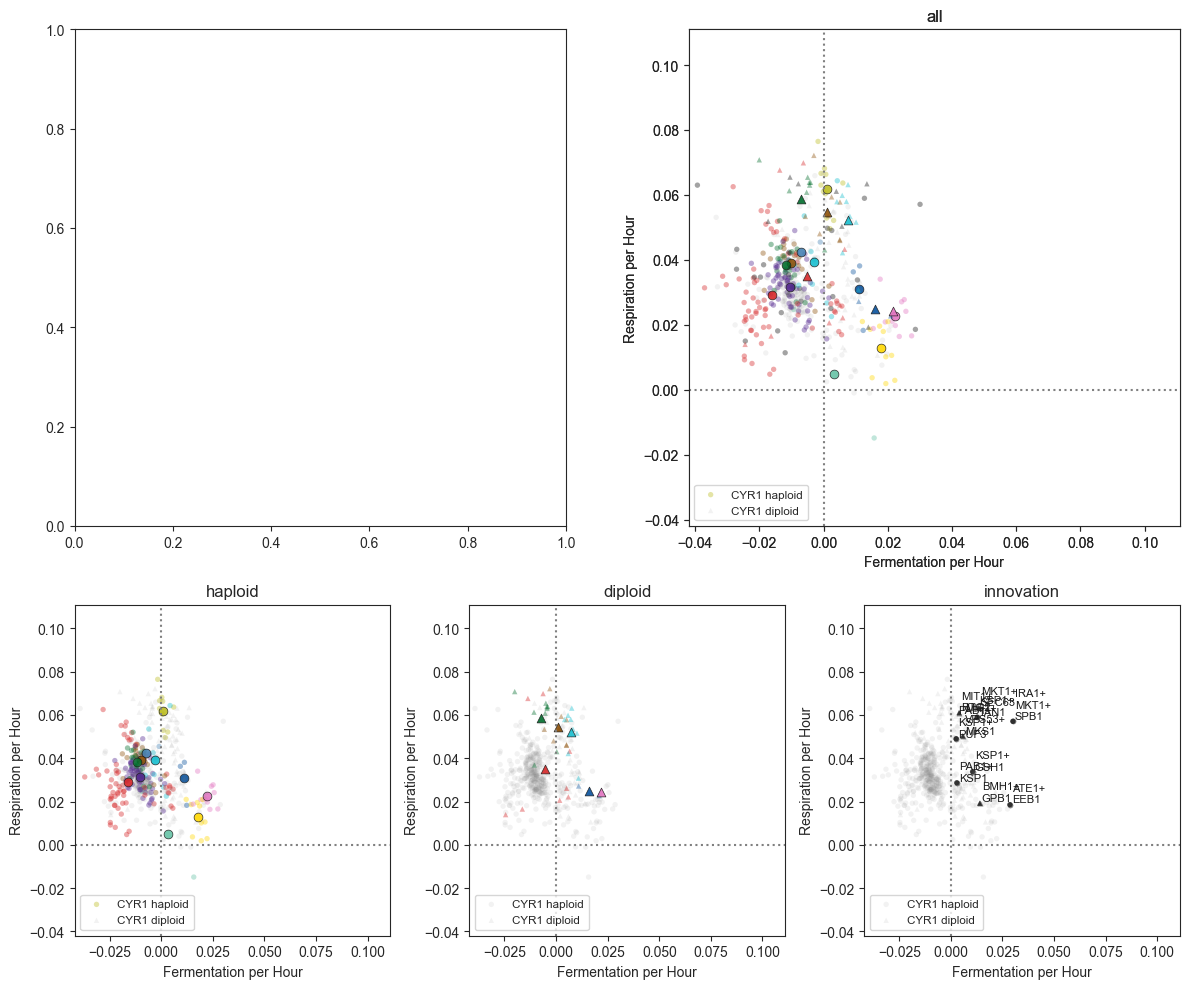

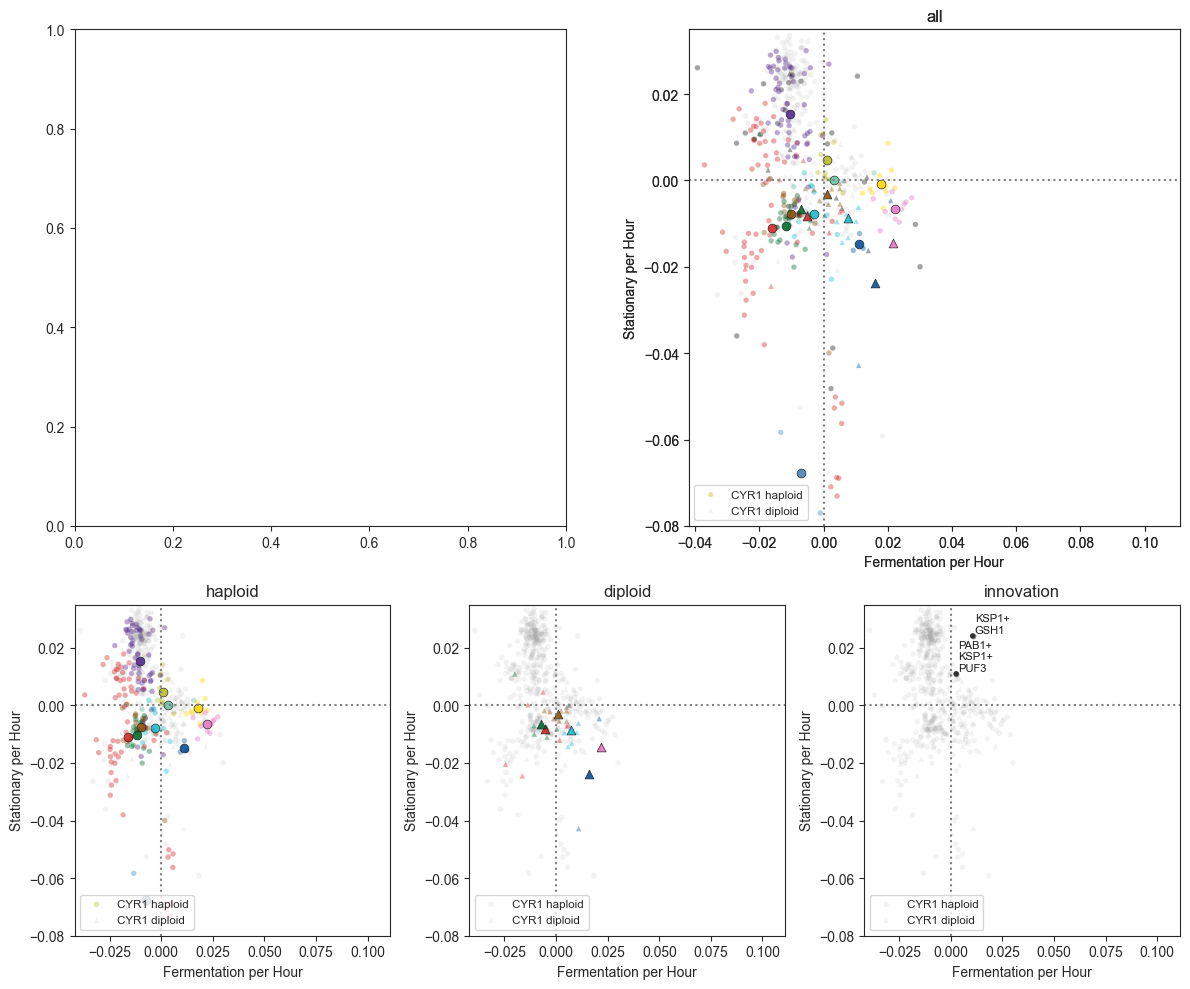

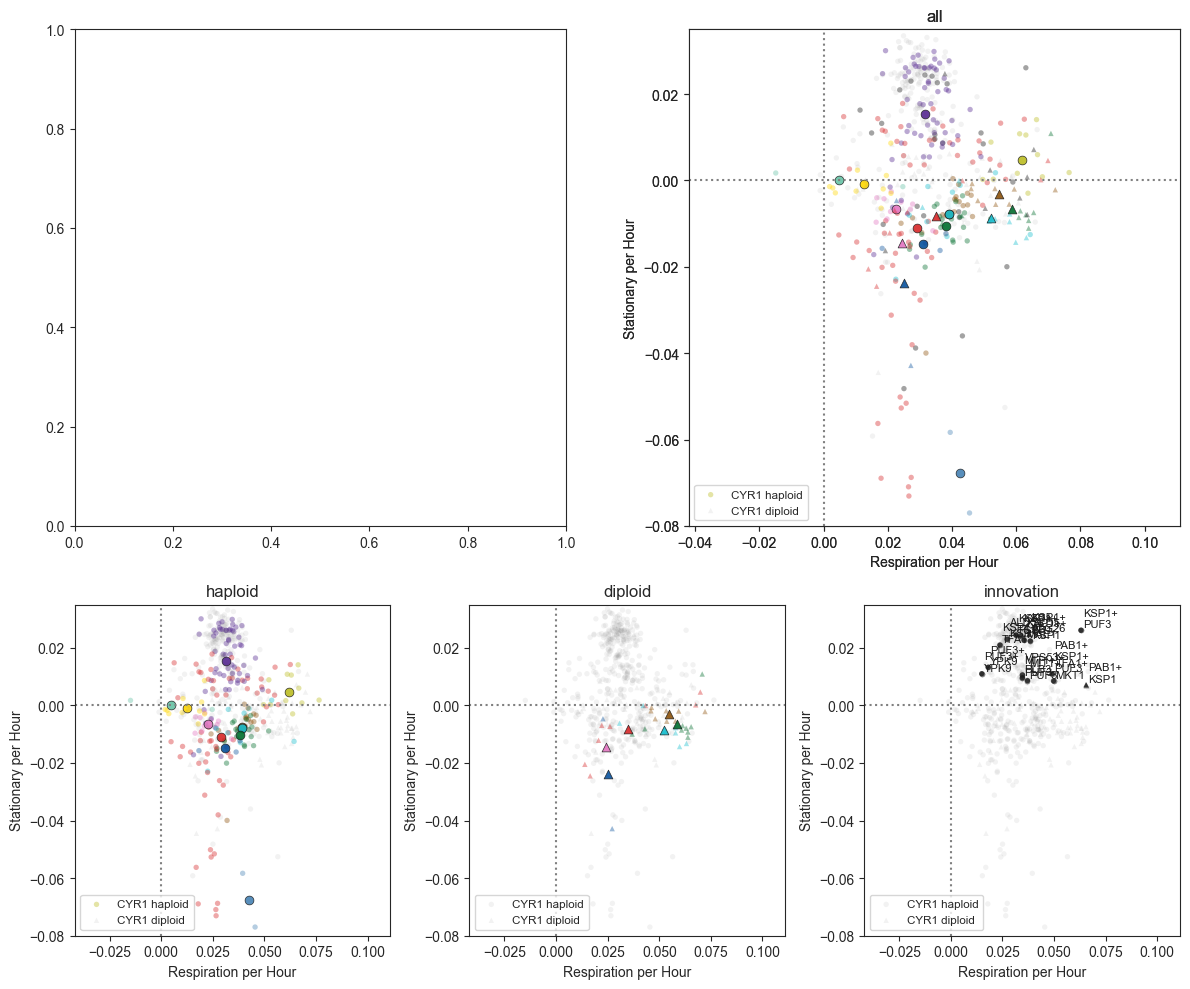

In [81]:
# colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
labels = {'FerPerHour_relative':'Fermentation per Hour','ResPerHour_relative':'Respiration per Hour','StaPerHour_relative':'Stationary per Hour'}



lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
evo_cond_list = ['Evo2D','Evo3D']

centroids = True
pathways = True
annotate = True

plot_sets = {'WT':['all'],
             'all_second_step':['all','haploid','diploid','innovation']}

for xdata,ydata in combinations(['FerPerHour_relative','ResPerHour_relative','StaPerHour_relative'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT'],['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']]
    fig = plt.figure(figsize=(12,10))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[1.5,1])
    few_inner_gs = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec = outer_gs[0],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        many_inner_gs = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        this_anc = this_anc[this_anc['evolution_condition'].isin(evo_cond_list)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        
        if ancs[0] == 'WT':
            fig.add_subplot(few_inner_gs[0])
            plot_sets_here = plot_sets['WT']
        else:
            plot_sets_here = plot_sets['all_second_step']
        
        for ps,plot_set in enumerate(plot_sets_here):
            if plot_set == 'all':
                fig.add_subplot(few_inner_gs[1])
                
                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
            else:
                fig.add_subplot(many_inner_gs[ps-1])
                
                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

            for ploidy,ploidy_list in {'haploid':['Haploid','haploid',np.nan,'?','NotSequenced','other'],'diploid':['diploid','Diploid']}.items():
                gene_list = {}

                this_data = interesting_muts[interesting_muts['ploidy_new'].isin(ploidy_list)]
                gray_alpha = 0.1
                if centroids:
                    bold_alpha = 0.4
                else:
                    bold_alpha = 0.7
    #             if len(ancs) < 2:
                if True:
                    colors = []
                    annotation_list = []
                    for e,gene in enumerate(this_data['gene'].values):
                        if plot_set != 'all':
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                        else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)

                        already_assigned = False
                        if (plot_set == 'all') or (plot_set == ploidy) or (plot_set == 'innovation'):
#                             print(plot_set)
                            if (not p.isnull(gene)) and (gene != 'NotSequenced'):
                                if gene in tools.mutation_color_map.keys() and (plot_set != 'innovation'):
                                    if pathways:
                                        color_assigned = matplotlib.colors.to_rgba(tools.find_pathway_color(gene),bold_alpha)
                                        pathway = tools.find_pathway(gene)
                                
                                        if pathway in gene_list.keys():
                                            gene_list[pathway].append(e)
                                        else:
                                            gene_list[pathway] = [e]
                                    else:
                                        color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map[gene],bold_alpha)
    
                                        if gene in gene_list.keys():
                                            gene_list[gene].append(e)
                                        else:
                        
                                            gene_list[gene] = [e]
                                elif '+' in gene:
                                    if plot_set == 'all':
                                        color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map['double_mutant'],bold_alpha)
                                    elif plot_set == 'innovation':
                                        
                                        for anc in ancestor_list[1]:
                                            if this_data['barcode'].values[e] in innovation_list[f'{xdata.replace("_relative","")}_{ydata.replace("_relative","")}'][f'{anc}']:
                                                annotation_list.append([e,gene])
                                                color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map['double_mutant'],0.8)
                                        

                        colors.append(color_assigned)

                    if centroids:
                        alpha = 0.3
                    else:
                        alpha = 0.7

                    plt.scatter(this_data[xdata].values,this_data[ydata].values,linewidths=0,
                                color=colors,marker=tools.ploidy_marker_map[ploidy],s=15,label=f'{ancs[0]} {ploidy}')

                    if centroids:
                        for gene,e_list in gene_list.items():

                            gene_centroid = tools.centroid(this_data[[xdata,ydata]].values[e_list,:])

                            plt.scatter(gene_centroid[0],gene_centroid[1],
                                    color=colors[e_list[0]],edgecolors='k',linewidth=0.5,
                                        marker=tools.ploidy_marker_map[ploidy],s=40,alpha=0.9)


                    for e,doubles in annotation_list:
                        if annotate:
                            plt.annotate(text=doubles.replace('+','+\n'),xy=(this_data[xdata].values[e],this_data[ydata].values[e]),
                                     xytext=(this_data[xdata].values[e]+0.001,this_data[ydata].values[e]+0.001),
                                     color='k',fontsize=8)
                        plt.scatter(this_data[xdata].values[e],this_data[ydata].values[e],
                                    marker=tools.ploidy_marker_map[ploidy],
                                    color='k',s=15,alpha=0.5,linewidth=0.2)

                    plt.legend(loc='lower left',fontsize='small')
                    plt.title(f'{plot_set}')
                    
            plt.xlabel(labels[xdata])
            plt.ylabel(labels[ydata])

            plt.axvline(0,color='gray',linestyle=':')
            plt.axhline(0,color='gray',linestyle=':')
        
        
        if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
            for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                resps = (fitness-16*ferms)/28 # 2day = 16*F
                
                norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                        vmax=np.nanmax(merged_fitness[fitness_colorby]))

                cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 
                
                plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
                plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')
            
        if len(ancs) > 1:
            if pathways:
                pathway_labels = []
                for g,gene in enumerate(tools.mutation_color_map.keys()):
                    if gene in tools.pathway_gene_map.keys():
                        pathway_labels.append(tools.pathway_gene_map[gene])
                    else:
                        pathway_labels.append(gene)
                
            else:
                for g,gene in enumerate(tools.mutation_color_map.keys()):
                    plt.text(y=0.4-0.02*(g%(len(tools.mutation_color_map.keys())/2)),x=0.01+0.1*int(g/len(tools.mutation_color_map.keys())*2),s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
    
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutationsplit.pdf',bbox_inches='tight')



In [76]:
annotation_list

[[4, 'MIT1+RTG2'],
 [5, 'PAB1+KSP1'],
 [14, 'BMH1+GPB1'],
 [30, 'PAB1+ATG26'],
 [32, 'KSP1+ATG26'],
 [37, 'MKT1+SEC63'],
 [39, 'MIT1+VPS53+MKS1'],
 [46, 'MIT1+CIT1']]

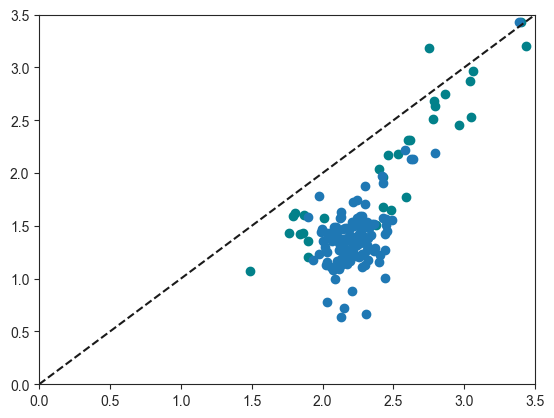

In [136]:
evo3d = merged_fitness[merged_fitness['evolution_condition']=='Evo3D']


for ancestor in ['IRA1_MIS','IRA1_NON']:
    
    this_anc = evo3d[evo3d['ancestor']==ancestor]

    plt.scatter(this_anc['Fit2D_early_fitness'],
                this_anc['Fit3D_early_fitness'],color=tools.anc_color_map[ancestor])
    
#     plt.scatter(this_anc['Fit2D_both2%5%_fitness'],
#                 this_anc['Fit3D_both2%5%_fitness'],
#                 color=tools.anc_color_map[ancestor],
#                marker='.')
    
plt.xlim(0,3.5)
plt.ylim(0,3.5)
plt.plot([0,3.5],[0,3.5],'k--')

Empty DataFrame
Columns: [gene, ploidy_new, class_new, FerPerHour, ResPerHour]
Index: []
         gene ploidy_new              class_new  FerPerHour  ResPerHour
25  ATE1+EEB1    haploid       adaptive_haploid    0.055942    0.055891
43  BMH1+GPB1    Diploid  high_fitness_diploids    0.041291    0.056582
Empty DataFrame
Columns: [gene, ploidy_new, class_new, FerPerHour, ResPerHour]
Index: []
                gene ploidy_new              class_new  FerPerHour  ResPerHour
5     IRA1+MKT1+SPB1    haploid       adaptive_haploid    0.062750    0.084059
15         MIT1+RTG2    diploid  high_fitness_diploids    0.036675    0.088092
746       MKT1+SEC63    diploid  high_fitness_diploids    0.046202    0.090395
787  MIT1+VPS53+MKS1    diploid  high_fitness_diploids    0.038413    0.077315
         gene ploidy_new         class_new  FerPerHour  ResPerHour
7   KSP1+TAN1          ?  adaptive_haploid    0.055608    0.088302
72  KSP1+GSH1    haploid  adaptive_haploid    0.053420    0.063144


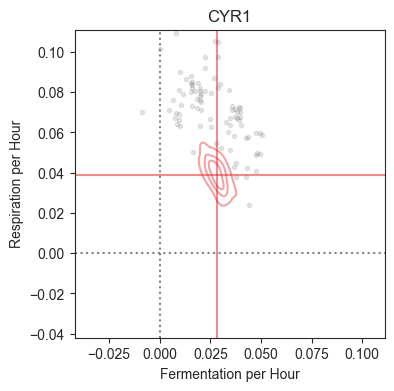

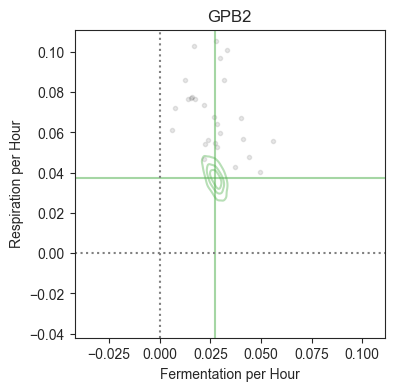

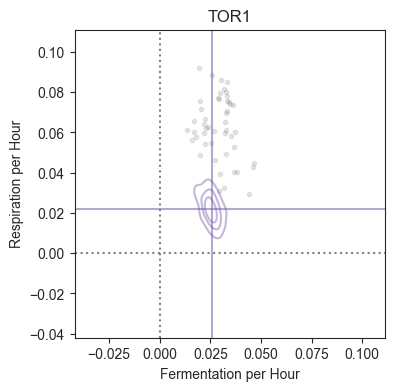

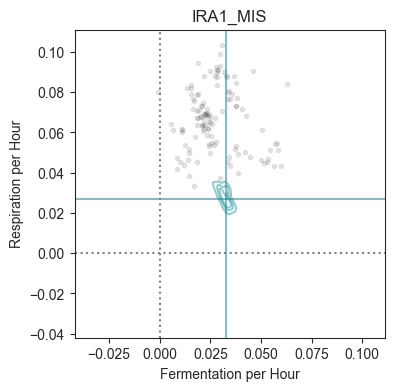

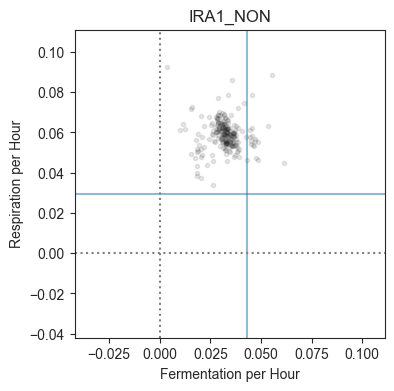

In [66]:

xdata = 'FerPerHour'
ydata = 'ResPerHour'

for anc in ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
    
    
    
    this_anc = noLi2019[(noLi2019['ancestor']==anc) & (noLi2019['evolution_condition'].isin(['Evo2D','Evo3D']))]
    this_set = this_anc[~this_anc['class_new'].isin(['pure_diploids','neutral_haploids'])]
    plt.scatter(this_set[xdata],this_set[ydata],marker='.',color='k',alpha=0.1)
    
    this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]
    this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]
    
    if len(this_neutral_haploid ) > 0:
        sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
    
#     for entry in innovators.:
#         print(entry)
    
    innovators = this_set[this_set['barcode'].isin(innovation_list[f'{xdata}_{ydata}'][anc])]
    if len(innovators) > 0:
        innovators = innovators[(innovators['gene'].str.contains('+',na=False,regex=False))]
        plt.figure(figsize=(4,4))
        plt.title(anc)
        
        
        print(innovators[['gene','ploidy_new','class_new',xdata,ydata]])
#     for 
    
#         plt.scatter(innovators[xdata],innovators[ydata],marker='o',color='k',alpha=0.5)
        
    plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.axhline(this_set[ydata+'_ancestor'].values[0],color=tools.anc_color_map[anc],alpha=0.5)
    plt.axvline(this_set[xdata+'_ancestor'].values[0],color=tools.anc_color_map[anc],alpha=0.5)
    
    plt.axvline(0,color='gray',linestyle=':')
    plt.axhline(0,color='gray',linestyle=':')
    
    plt.xlabel('Fermentation per Hour')
    plt.ylabel('Respiration per Hour')
    
    
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/innovation_{anc}_{gene}.pdf',bbox_inches='tight')
    


In [106]:
interesting_genes = {'IRA1_NON':['KSP1+TAN1','KSP1+GSH1','KSP1+PUF3'],
                     'IRA1_MIS':['IRA1+MKT1+SPB1'],
#                      'GPB2':[]
                    }

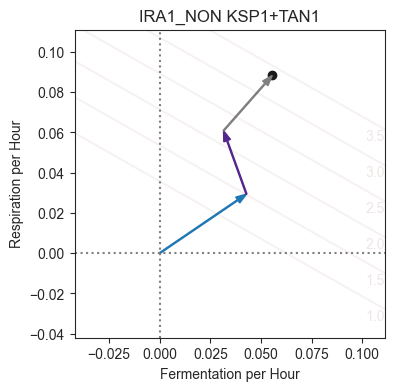

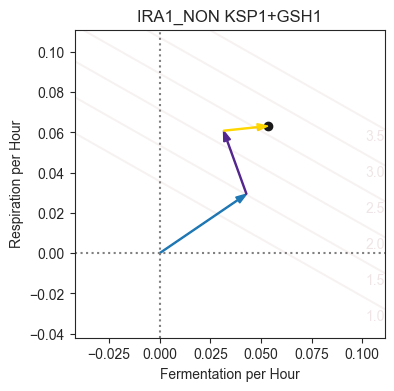

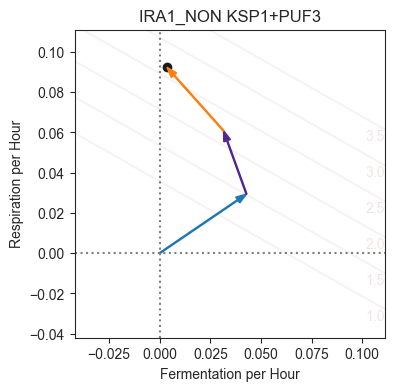

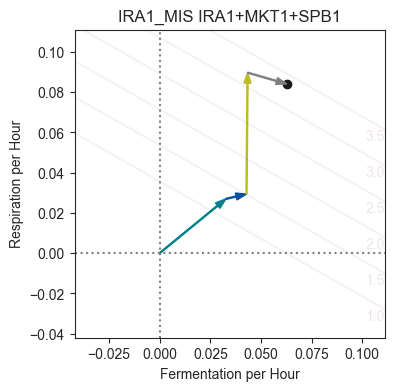

In [107]:

xdata = 'FerPerHour'
ydata = 'ResPerHour'

arrow_args = {'length_includes_head':True,
              'width':0.0005,
              'head_width':7*0.0005
             }

for anc,gene_list in interesting_genes.items():
    
    this_anc = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['evolution_condition'].isin(['Evo2D','Evo3D']))]
    this_set = this_anc[~this_anc['class_new'].isin(['pure_diploids','neutral_haploids'])]
#     plt.scatter(this_set[xdata],this_set[ydata],marker='.',color='k',alpha=0.1) 
    this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]
    this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]
    adaptive_haploids = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='adaptive_haploid')]
    
    for gene_set in gene_list:
        
        plt.figure(figsize=(4,4))
        plt.title(f'{anc} {gene_set}')
        
        diploid = False
        this_mutant = this_set[this_set['gene']==gene_set]
        if this_mutant['class_new'].values[0] != 'adaptive_haploid':
            diploid = True
        
        plt.scatter(this_mutant[xdata],this_mutant[ydata],color='k',marker='o')
        
        location = np.asarray([0,0])
        
        plt.arrow(location[0],location[1],
                  this_set[xdata+'_ancestor'].values[0],
                  this_set[ydata+'_ancestor'].values[0],
                 color=tools.anc_color_map[anc],**arrow_args)
        
        location = location + [this_set[xdata+'_ancestor'].values[0],this_set[ydata+'_ancestor'].values[0]]
        
        if diploid:
            plt.arrow(location[0],location[1],
                  np.median(this_pure_diploid[xdata+'_relative'].values),
                      np.median(this_pure_diploid[xdata+'_relative'].values),
                 color='k',linestyle='--',**arrow_args)
            
            location = location +  [np.median(this_pure_diploid[xdata+'_relative'].values),
                      np.median(this_pure_diploid[xdata+'_relative'].values)]
        
        genes_unfurled = gene_set.split('+')
        
        for gene in genes_unfurled:
            
            if gene == 'IRA1':
                
                    this_gene = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants['IRA1_NON']]
                    
                    plt.arrow(location[0],location[1],
                          np.median(this_gene[xdata+'_relative'].values)-location[0],
                         np.median(this_gene[ydata+'_relative'].values)-location[1],
                         color=tools.mutation_color_map[gene],linestyle='-',**arrow_args)

                    location = location+ [np.median(this_gene[xdata+'_relative'].values)-location[0],
                                        np.median(this_gene[ydata+'_relative'].values)-location[1]]


                
            
            elif gene != genes_unfurled[-1]:
            
                this_gene = adaptive_haploids[adaptive_haploids['gene']==gene]
    #             np.median()

                if len(this_gene) > 1:

                    plt.arrow(location[0],location[1],
                          np.median(this_gene[xdata+'_relative'].values),
                         np.median(this_gene[ydata+'_relative'].values),
                         color=tools.mutation_color_map[gene],linestyle='-',**arrow_args)

                    location = location+ [np.median(this_gene[xdata+'_relative'].values),np.median(this_gene[ydata+'_relative'].values)]
            else:
                
                plt.arrow(location[0],location[1],
                      this_mutant[xdata].values[0]-location[0],this_mutant[ydata].values[0]-location[1],
                     color=tools.find_mutation_color(gene),linestyle='-',**arrow_args)
        
        
        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

#         plt.axhline(this_set[ydata+'_ancestor'].values[0],color=tools.anc_color_map[anc],alpha=0.5)
#         plt.axvline(this_set[xdata+'_ancestor'].values[0],color=tools.anc_color_map[anc],alpha=0.5)

        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')

        plt.xlabel('Fermentation per Hour')
        plt.ylabel('Respiration per Hour')
        
        for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
            ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
            resps = (fitness-16*ferms)/28 # 2day = 16*F

            norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                    vmax=np.nanmax(merged_fitness[fitness_colorby]))

            cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 

            plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
            plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')


        plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/innovation_{anc}_{gene_set}.pdf',bbox_inches='tight')

        

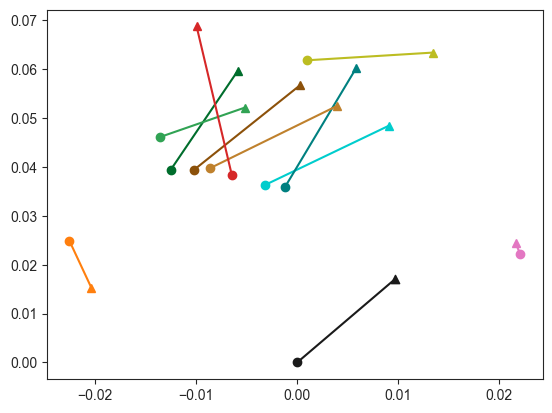

In [160]:
xdata = 'FerPerHour'
ydata = 'ResPerHour'

plt.figure()


this_study = merged_fitness[(merged_fitness['ancestor']!='WT')]
# haploids = this_study[this_gene['class_new']=='adaptive_haploid']
diploids = this_study[this_study['class_new']=='pure_diploids']


plt.scatter(0,0,color='k')

plt.scatter(np.mean(diploids[xdata+'_relative'].values),
            np.mean(diploids[ydata+'_relative'].values),
            color='k',marker='^')
    
        
plt.plot(
        [0,
         np.mean(diploids[xdata+'_relative'].values)
         ],
        [0,
         np.mean(diploids[ydata+'_relative'].values)],
        color=tools.find_mutation_color(gene),marker=''
    )

for gene in tools.mutation_color_map.keys():
    
    if gene != 'ALD5':

        this_gene = merged_fitness[(merged_fitness['ancestor']!='WT') & (merged_fitness['gene']==gene)]

        haploids = this_gene[this_gene['class_new']=='adaptive_haploid']
        diploids = this_gene[this_gene['class_new']=='high_fitness_diploids']

        if len(haploids) > 0 and len(diploids) > 0:

            plt.scatter(
                np.mean(haploids[xdata+'_relative'].values),
                np.mean(haploids[ydata+'_relative'].values),
                color=tools.find_mutation_color(gene)
            )

            plt.plot(
                 np.mean(diploids[xdata+'_relative'].values),
                np.mean(diploids[ydata+'_relative'].values),
                color=tools.find_mutation_color(gene),marker='^'
            )


            plt.plot(
                [np.mean(haploids[xdata+'_relative'].values),
                 np.mean(diploids[xdata+'_relative'].values)
                 ],
                [np.mean(haploids[ydata+'_relative'].values),
                 np.mean(diploids[ydata+'_relative'].values)],
                color=tools.find_mutation_color(gene),marker=''
            )

        

In [110]:
matplotlib.colors.rgb2hex(tools.long_colors[1])

'#ff7f0e'

In [133]:
[np.median(haploids[xdata+'_relative'].values),
             np.median(haploids[ydata+'_relative'].values)]

[0.0309562348259814, -0.0193485750507704]

In [134]:
[np.median(diploids[xdata+'_relative'].values),
             np.median(diploids[ydata+'_relative'].values)]

[0.0246438184530072, -0.015225139290884]

In [62]:
merged_fitness[merged_fitness['gene']=='ALD5']['all_mutations_verbose'].values

array(['II:610499:A:T:MED8:upstream_gene_variant:c.-746T>A:nan:1/1~V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan:0/1~X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr:0/1~XII:196744:T:A:UBR2:upstream_gene_variant:c.-3463A>T:nan:0/1~XVI:940751:T:G:ARR3:missense_variant:c.830T>G:p.Ile277Ser:0/1',
       'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan:1/1~VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan:1/1~XII:841888:C:A:RSC2:synonymous_variant:c.558C>A:p.Val186Val:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1'],
      dtype=object)

In [15]:
merged_fitness[merged_fitness['ancestor'].isin(['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']) 
               & (merged_fitness['evolution_condition']=='Evo1D') &  ~p.isnull(merged_fitness['all_mutations_verbose'])][['barcode','evolution_condition','ancestor','gene','all_mutations_verbose']].to_csv(f'{home_dir}/data/old/SecondStep_Evo1D_sequenced.csv',index=False)

In [5]:
list(merged_fitness.columns)

['Fit1D-2%-R1_fitness',
 'Fit1D-2%-R1_error',
 'Fit1D-2%-R2_fitness',
 'Fit1D-2%-R2_error',
 'Fit1D-5%-R1_fitness',
 'Fit1D-5%-R1_error',
 'Fit1D-5%-R2_fitness',
 'Fit1D-5%-R2_error',
 'Fit2D-2%-R1_fitness',
 'Fit2D-2%-R1_error',
 'Fit2D-2%-R2_fitness',
 'Fit2D-2%-R2_error',
 'Fit2D-5%-R1_fitness',
 'Fit2D-5%-R1_error',
 'Fit2D-5%-R2_fitness',
 'Fit2D-5%-R2_error',
 'Fit3D-2%-R1_fitness',
 'Fit3D-2%-R1_error',
 'Fit3D-2%-R2_fitness',
 'Fit3D-2%-R2_error',
 'Fit3D-2%-R3_fitness',
 'Fit3D-2%-R3_error',
 'Fit3D-5%-R1_fitness',
 'Fit3D-5%-R1_error',
 'Fit3D-5%-R2_fitness',
 'Fit3D-5%-R2_error',
 'Fit3D-5%-R3_fitness',
 'Fit3D-5%-R3_error',
 'Fit5D-2%-R1_fitness',
 'Fit5D-2%-R1_error',
 'Fit5D-2%-R2_fitness',
 'Fit5D-2%-R2_error',
 'Fit5D-2%-R3_fitness',
 'Fit5D-2%-R3_error',
 'Fit5D-5%-R1_fitness',
 'Fit5D-5%-R1_error',
 'Fit5D-5%-R2_fitness',
 'Fit5D-5%-R2_error',
 'Fit5D-5%-R3_fitness',
 'Fit5D-5%-R3_error',
 'BCID',
 'Fit1D-5%-R1-T2',
 'Fit5D-2%-R2-T2-PCRb',
 'Fit1D-2%-R1-T4',
 'Fit5D-2

In [ ]:
merged